In [1]:
# pip3 install nltk requests networkx matplotlib pandas numpy scipy python-dateutil
# pip install networkx
# pip install matplotlib
# pip install pandas
# pip install numpy
# pip install scipy
# pip install python-dateutil
# pip install requests
import requests
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

In [ ]:
def get_wikipedia_section_titles(article_title):
    base_url = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "parse",
        "page": article_title,
        "format": "json",
        "prop": "sections"}
    response = requests.get(base_url, params=params)
    data = response.json()
    sections = data['parse']['sections']
    section_titles = [section['line'] for section in sections]
    return section_titles


def add_section_count_to_df(df):
    section_count_dict = {}
    for index, row in df.iterrows():
        topic = row['Topic']
        if topic not in section_count_dict:
            # section count for this topic
            section_titles = get_wikipedia_section_titles(topic)
            section_count = len(section_titles)
            section_count_dict[topic] = section_count
        else:
            # already known section count
            section_count = section_count_dict[topic]
        df.at[index, 'Section_Count'] = section_count

    return df

In [2]:
def get_edit_history(title, start_time='2019-01-01T00:00:00Z', end_time='2023-05-15T00:00:00Z'):
    base_url = 'https://en.wikipedia.org/w/api.php'
    params = {
        'action': 'query',
        'format': 'json',
        'prop': 'revisions',
        'titles': title,
        'rvlimit': 1000,
        'rvprop': 'user|timestamp|content',
        'rvstart': start_time,
        'rvend': end_time,
        'rvdir': 'newer',  # older to newer
        'formatversion': 2
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    page = data['query']['pages'][0]
    earliest_revision = page['revisions'][0]
#     print('earliest_revision is', earliest_revision)
    return page['revisions']

C:\Users\negin\AppData\Local\Temp\ipykernel_14556\169922733.py:54: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


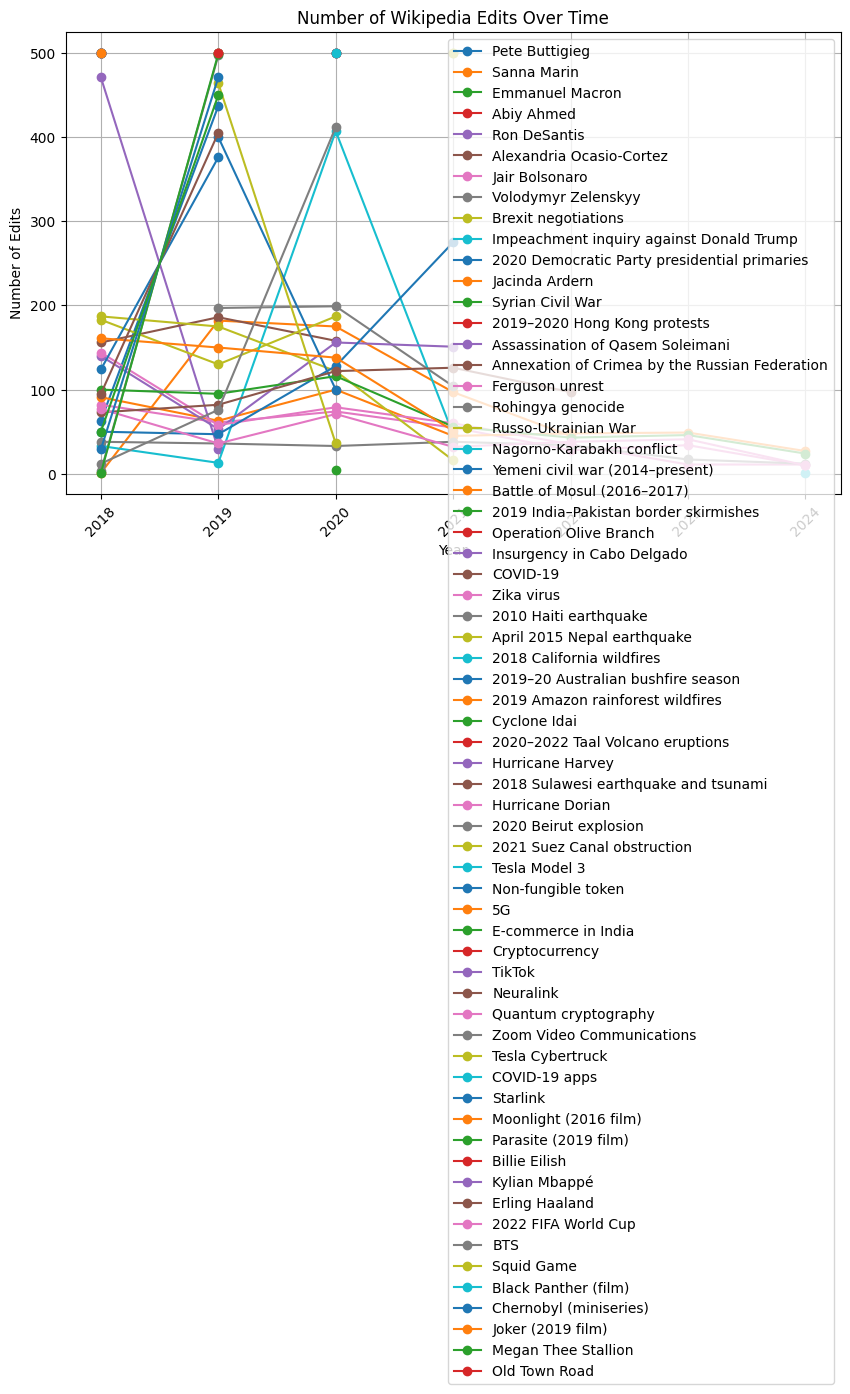

In [4]:
def get_edit_history(title, start_time='2018-01-01T00:00:00Z', end_time='2024-05-15T00:00:00Z'):
    base_url = 'https://en.wikipedia.org/w/api.php'
    params = {
        'action': 'query',
        'format': 'json',
        'prop': 'revisions',
        'titles': title,
        'rvlimit': 1000,
        'rvprop': 'timestamp',
        'rvstart': start_time,
        'rvend': end_time,
        'rvdir': 'newer',
        'formatversion': 2
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    try:
        page = data['query']['pages'][0]
        return page['revisions'] if 'revisions' in page else []
    except KeyError:
        return []

# # Topics list example
# topics_all = ['Python (programming language)', 'Java (programming language)', 'C++']

edit_counts_by_year = defaultdict(lambda: defaultdict(int))

for topic in topics_all:
    revisions = get_edit_history(topic)
    for revision in revisions:
        year = pd.to_datetime(revision['timestamp']).year
        edit_counts_by_year[topic][year] += 1

plt.figure(figsize=(10, 6))

for topic, counts in edit_counts_by_year.items():
    years = list(counts.keys())
    edits = list(counts.values())
    plt.plot(years, edits, marker='o', label=topic)

plt.title('Number of Wikipedia Edits Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Edits')
plt.legend()
plt.grid(True)
plt.xticks(sorted(list(set(year for counts in edit_counts_by_year.values() for year in counts))), rotation=45)
plt.tight_layout()
plt.show()


In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    # remove stopwords
    filtered_tokens = [word for word in tokens if word not in stopwords.words('english') and word.isalpha()]
    return filtered_tokens

def guess_topic(text, topics):
    processed_text = preprocess_text(text)
    topic_scores = {topic: 0 for topic in topics}

    for word in processed_text:
        for topic in topics:
            # keyword matching
            topic_keywords = topic.lower().split()
            for keyword in topic_keywords:
                if keyword in word:
                    topic_scores[topic] += 1
    sorted_topics = sorted(topic_scores, key=topic_scores.get, reverse=True)
    return [topic for topic in sorted_topics if topic_scores[topic] > 0]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\negin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\negin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Network Analysis

In [4]:
def get_article_creation_date(title):
    base_url = 'https://en.wikipedia.org/w/api.php'
    params = {
        'action': 'query',
        'format': 'json',
        'prop': 'revisions',
        'titles': title,
        'rvlimit': 1,
        'rvdir': 'newer',  #from older to newer
        'formatversion': 2
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    page = data['query']['pages'][0]
    creation_date = page['revisions'][0]['timestamp']
    return creation_date


def get_earliest_edit(title):
    base_url = 'https://en.wikipedia.org/w/api.php'
    params = {
        'action': 'query',
        'format': 'json',
        'prop': 'revisions',
        'titles': title,
        'rvlimit': 1,
        'rvprop': 'user|timestamp',
        'rvdir': 'newer',  # from older to newer
        'formatversion': 2
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    page = data['query']['pages'][0]
    earliest_revision = page['revisions'][0]
    last_revision = page['revisions'][-1]

    return earliest_revision, last_revision


def generate_dates(start, end, month_interval):
    start_date = datetime.strptime(start, '%Y-%m-%dT%H:%M:%SZ')
    end_date = datetime.strptime(end, '%Y-%m-%dT%H:%M:%SZ')
    dates = []
    current_date = start_date
    while current_date <= end_date:
        dates.append(current_date.strftime('%Y-%m-%dT%H:%M:%SZ'))
        # add month_interval months to current date
        current_date = current_date + relativedelta(months=month_interval)

    return dates

In [5]:
import requests
from datetime import datetime
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import requests
import networkx as nx
from collections import defaultdict
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import linregress
from scipy.stats import pearsonr
from datetime import datetime, timedelta
from collections import defaultdict
import math

In [6]:
# #To calculate content weights from the top:

# def calculate_weights(title, start_time, end_time, interaction_window_hours=48):
#     edit_history = get_edit_history(title, start_time, end_time)
#     section_titles = get_wikipedia_section_titles(title)

#     user_edits = defaultdict(lambda: {'timestamps': [], 'contents': []})
#     for revision in edit_history:
#         timestamp = datetime.strptime(revision['timestamp'], '%Y-%m-%dT%H:%M:%SZ')
#         user = revision['user']
#         content = revision.get('content', '')
#         user_edits[user]['timestamps'].append(timestamp)
#         user_edits[user]['contents'].append(content)
        
#     print(f"number of unique users in this time window: {len(user_edits)}")
    
#     user_topics = {}
#     for user, edits in user_edits.items():
#         contents = " ".join(edits['contents'])
#         user_topics[user] = set(guess_topic(contents, section_titles))

#     all_weights = defaultdict(dict)
#     user_list = sorted(user_edits.keys())

#     for i, user_a in enumerate(user_list):
#         topics_a = user_topics[user_a]

#         for user_b in user_list[i+1:]:
#             T_weight = sum(1 for timestamp_a in user_edits[user_a]['timestamps']
#                            for timestamp_b in user_edits[user_b]['timestamps']
#                            if abs(timestamp_a - timestamp_b) <= timedelta(hours=interaction_window_hours))

#             total_revisions = len(user_edits[user_a]['timestamps']) * len(user_edits[user_b]['timestamps'])

#             topics_b = user_topics[user_b]
#             C_weight = len(topics_a.intersection(topics_b))

#             if T_weight > 0 and C_weight > 0:
#                 normalized_T_weight = (T_weight) / total_revisions if total_revisions > 0 else 0
#                 normalized_C_weight = C_weight / len(section_titles)

#                 all_weights[(user_a, user_b)] = [normalized_T_weight, normalized_C_weight]

#     return all_weights

# weightss_df.to_csv('all_weightsAASNEW.csv', index=False)

In [7]:
# We have all the content weights:
weightss_df=pd.read_csv('AAS_Tweights.csv')
weightss_df

,Topic,Period,User_A,User_B,T_Weight,Normalized_C_Weight
0,Pete Buttigieg,"('2011-11-09T06:38:28Z', '2012-05-09T06:38:28Z')",173.161.20.78,173.195.80.124,1,0.485714
1,Pete Buttigieg,"('2011-11-09T06:38:28Z', '2012-05-09T06:38:28Z')",173.161.20.78,50.103.139.33,0,0.485714
2,Pete Buttigieg,"('2011-11-09T06:38:28Z', '2012-05-09T06:38:28Z')",173.161.20.78,63.206.189.49,0,0.485714
3,Pete Buttigieg,"('2011-11-09T06:38:28Z', '2012-05-09T06:38:28Z')",173.161.20.78,98.228.124.99,0,0.485714
4,Pete Buttigieg,"('2011-11-09T06:38:28Z', '2012-05-09T06:38:28Z')",173.161.20.78,Alpha Quadrant,0,0.485714
...,...,...,...,...,...,...
233095,Old Town Road,"('2023-03-27T20:36:43Z', '2023-09-27T20:36:43Z')",SibTower1987,Theknine2,0,0.842105
233096,Old Town Road,"('2023-03-27T20:36:43Z', '2023-09-27T20:36:43Z')",SibTower1987,YGO24895,0,0.842105
233097,Old Town Road,"('2023-03-27T20:36:43Z', '2023-09-27T20:36:43Z')",The Night Watch,Theknine2,0,0.842105
233098,Old Town Road,"('2023-03-27T20:36:43Z', '2023-09-27T20:36:43Z')",The Night Watch,YGO24895,0,0.842105


In [9]:
# fildf = weightss_df[weightss_df["T_Weight"]>0]
# # fildf =fildf[fildf["User_A"]=="Anthony Appleyard"]
# fildf

,Topic,Period,User_A,User_B,T_Weight,Normalized_C_Weight
0,Pete Buttigieg,"('2011-11-09T06:38:28Z', '2012-05-09T06:38:28Z')",173.161.20.78,173.195.80.124,1,0.485714
50,Pete Buttigieg,"('2011-11-09T06:38:28Z', '2012-05-09T06:38:28Z')",Alpha Quadrant,Streeling,1,0.485714
54,Pete Buttigieg,"('2011-11-09T06:38:28Z', '2012-05-09T06:38:28Z')",AnomieBOT,Ser Amantio di Nicolao,1,0.485714
55,Pete Buttigieg,"('2011-11-09T06:38:28Z', '2012-05-09T06:38:28Z')",AnomieBOT,Streeling,1,0.485714
65,Pete Buttigieg,"('2011-11-09T06:38:28Z', '2012-05-09T06:38:28Z')",Ser Amantio di Nicolao,Streeling,2,0.485714
...,...,...,...,...,...,...
232888,Old Town Road,"('2022-09-27T20:36:43Z', '2023-03-27T20:36:43Z')",Jimoincolor,YGO24895,1,0.842105
232951,Old Town Road,"('2023-03-27T20:36:43Z', '2023-09-27T20:36:43Z')",2607:FEA8:13E3:100:E88C:2EA1:E286:C12C,Binksternet,1,0.842105
232992,Old Town Road,"('2023-03-27T20:36:43Z', '2023-09-27T20:36:43Z')",77.103.77.18,The Night Watch,1,0.842105
232997,Old Town Road,"('2023-03-27T20:36:43Z', '2023-09-27T20:36:43Z')",Aithus,BrDen,1,0.842105


In [10]:
weightss_df['Normalized_C_Weight'] = pd.to_numeric(weightss_df['Normalized_C_Weight'], errors='coerce')
weightss_df['T_Weight'] = pd.to_numeric(weightss_df['T_Weight'], errors='coerce')

weightss_df[['start_period', 'end_period']] = weightss_df['Period'].str.extract(r"\('([^']*)', '([^']*)'\)")
weightss_df['start_period'] = pd.to_datetime(weightss_df['start_period'])
weightss_df['end_period'] = pd.to_datetime(weightss_df['end_period'])
weightss_df

,Topic,Period,User_A,User_B,T_Weight,Normalized_C_Weight,start_period,end_period
0,Pete Buttigieg,"('2011-11-09T06:38:28Z', '2012-05-09T06:38:28Z')",173.161.20.78,173.195.80.124,1,0.485714,2011-11-09 06:38:28+00:00,2012-05-09 06:38:28+00:00
1,Pete Buttigieg,"('2011-11-09T06:38:28Z', '2012-05-09T06:38:28Z')",173.161.20.78,50.103.139.33,0,0.485714,2011-11-09 06:38:28+00:00,2012-05-09 06:38:28+00:00
2,Pete Buttigieg,"('2011-11-09T06:38:28Z', '2012-05-09T06:38:28Z')",173.161.20.78,63.206.189.49,0,0.485714,2011-11-09 06:38:28+00:00,2012-05-09 06:38:28+00:00
3,Pete Buttigieg,"('2011-11-09T06:38:28Z', '2012-05-09T06:38:28Z')",173.161.20.78,98.228.124.99,0,0.485714,2011-11-09 06:38:28+00:00,2012-05-09 06:38:28+00:00
4,Pete Buttigieg,"('2011-11-09T06:38:28Z', '2012-05-09T06:38:28Z')",173.161.20.78,Alpha Quadrant,0,0.485714,2011-11-09 06:38:28+00:00,2012-05-09 06:38:28+00:00
...,...,...,...,...,...,...,...,...
233095,Old Town Road,"('2023-03-27T20:36:43Z', '2023-09-27T20:36:43Z')",SibTower1987,Theknine2,0,0.842105,2023-03-27 20:36:43+00:00,2023-09-27 20:36:43+00:00
233096,Old Town Road,"('2023-03-27T20:36:43Z', '2023-09-27T20:36:43Z')",SibTower1987,YGO24895,0,0.842105,2023-03-27 20:36:43+00:00,2023-09-27 20:36:43+00:00
233097,Old Town Road,"('2023-03-27T20:36:43Z', '2023-09-27T20:36:43Z')",The Night Watch,Theknine2,0,0.842105,2023-03-27 20:36:43+00:00,2023-09-27 20:36:43+00:00
233098,Old Town Road,"('2023-03-27T20:36:43Z', '2023-09-27T20:36:43Z')",The Night Watch,YGO24895,0,0.842105,2023-03-27 20:36:43+00:00,2023-09-27 20:36:43+00:00


In [11]:
# average of the T_Weight column
average_T_Weight = fildf['T_Weight'].mean()
print("Average T_Weight:", average_T_Weight)

# average of the Normalized_C_Weight column
average_Normalized_C_Weight = fildf['Normalized_C_Weight'].mean()
print("Average Normalized_C_Weight:", average_Normalized_C_Weight)


Average T_Weight: 1.1500909122096812
Average Normalized_C_Weight: 0.7192989249136076


In [9]:
# def get_number_of_edits(user, title, start_time, end_time):
# #     print(user)
# #     print("title is", title)
# #     print("start is:", start_time)
#     try:
#         edit_history = get_edit_history(title, start_time, end_time)
#         return sum(1 for revision in edit_history if revision['user'] == user)
#     except Exception as e:
#         print(f"Error in getting edit history: {e}")
#         return 0


In [10]:
# # loop through each unique topic
# for topic in weightss_df['Topic'].unique():
#     print(f"Processing topic: {topic}")

#     topic_df = weightss_df[weightss_df['Topic'] == topic]
#     for index, row in topic_df.iterrows():
#         if row['Normalized_T_Weight'] > 0:
#             user_a_edits = get_number_of_edits(row['User_A'], topic, row['start_period'], row['end_period'])
#             user_b_edits = get_number_of_edits(row['User_B'], topic, row['start_period'], row['end_period'])
#             weightss_df.at[index, 'User_A_Edits'] = user_a_edits
#             weightss_df.at[index, 'User_B_Edits'] = user_b_edits
#         else:
#             weightss_df.at[index, 'User_A_Edits'] = 0
#             weightss_df.at[index, 'User_B_Edits'] = 0

#     print(f"Finished processing topic: {topic}")


In [12]:
# np.max([weightss_df["Normalized_T_Weight"]])

In [12]:
import math
from datetime import datetime, timedelta
from collections import defaultdict

def calculate_weights(title, start_time, end_time, interaction_window_hours):
    edit_history = get_edit_history(title, start_time, end_time)

    user_edits = defaultdict(lambda: {'timestamps': [], 'contents': []})
    for revision in edit_history:
        timestamp = datetime.strptime(revision['timestamp'], '%Y-%m-%dT%H:%M:%SZ')
        user = revision['user']
        content = revision.get('content', '')
        user_edits[user]['timestamps'].append(timestamp)
        user_edits[user]['contents'].append(content)

    print(f"Number of unique users in this time window: {len(user_edits)}")

    all_weights = defaultdict(dict)
    user_list = sorted(user_edits.keys())
    print(user_list)

    for i, user_a in enumerate(user_list):
#         print("Processing user:", user_a)
        for user_b in user_list[i+1:]:
#             print("user b is then", user_b)
            # a single list of all revisions with user information
            all_revisions = [{'timestamp': timestamp, 'user': 'a'} for timestamp in user_edits[user_a]['timestamps']] + \
                            [{'timestamp': timestamp, 'user': 'b'} for timestamp in user_edits[user_b]['timestamps']]
    
            # sort
            all_revisions.sort(key=lambda x: x['timestamp'])
#             print(all_revisions)
            T_weight = 0
            # going through the revisions, comparing each with its next one
            for j in range(len(all_revisions) - 1):
                current_revision = all_revisions[j]
                next_revision = all_revisions[j + 1]

                # check if the revisions are by different users and within the interaction window
                if current_revision['user'] != next_revision['user'] and \
                   abs(next_revision['timestamp'] - current_revision['timestamp']) <= timedelta(hours=interaction_window_hours):
                    T_weight += 1
#                 print(T_weight)
            
            
#             # Normalize temporal weight (T_weight)
#             normalization_factor = len(user_edits[user_a]['timestamps']) + len(user_edits[user_b]['timestamps'])
#             normalized_T_weight = T_weight / normalization_factor if normalization_factor > 0 else 0

            normalized_C_weight = None
            if weightss_df is not None:
                filtered_df = weightss_df[(weightss_df['start_period'] == start_time) & 
                                         (weightss_df['end_period'] == end_time) &
                                         ((weightss_df['User_A'] == user_a) & (weightss_df['User_B'] == user_b)) |
                                         ((weightss_df['User_A'] == user_b) & (weightss_df['User_B'] == user_a))]

                if not filtered_df.empty:
                    normalized_C_weight = filtered_df.iloc[0]['Normalized_C_Weight']
            
            # content-based weight if not found in weights_df
            if normalized_C_weight is None:
                normalized_C_weight="not there"
                section_titles = get_wikipedia_section_titles(title)
                topics_a = set(guess_topic(" ".join(user_edits[user_a]['contents']), section_titles))
                topics_b = set(guess_topic(" ".join(user_edits[user_b]['contents']), section_titles))
                C_weight = len(topics_a.intersection(topics_b))
                normalized_C_weight = C_weight / len(section_titles) if len(section_titles) > 0 else 0
#             print("normalized_C_weight is", normalized_C_weight)

            all_weights[(user_a, user_b)] = [T_weight, normalized_C_weight]
    return all_weights

In [3]:
topics_all=[]
topics_politics = ['Pete Buttigieg', 'Sanna Marin', 'Emmanuel Macron', 'Abiy Ahmed','Ron DeSantis', 'Alexandria Ocasio-Cortez', 'Jair Bolsonaro', 'Volodymyr Zelenskyy', 'Brexit negotiations', 'Impeachment inquiry against Donald Trump', '2020 Democratic Party presidential primaries', 'Jacinda Ardern']
topics_conflicts = ['Syrian Civil War', '2019–2020 Hong Kong protests', 'Assassination of Qasem Soleimani', 'Annexation of Crimea by the Russian Federation', 'Ferguson unrest', 'Rohingya genocide', 'Russo-Ukrainian War', 'Nagorno-Karabakh conflict', 'Yemeni civil war (2014–present)', 'Battle of Mosul (2016–2017)', '2019 India–Pakistan border skirmishes', 'Operation Olive Branch', 'Insurgency in Cabo Delgado']
topics_disasters = ['COVID-19', 'Zika virus', '2010 Haiti earthquake', 'April 2015 Nepal earthquake', '2018 California wildfires', '2019–20 Australian bushfire season', '2019 Amazon rainforest wildfires', 'Cyclone Idai', '2020–2022 Taal Volcano eruptions', 'Hurricane Harvey', '2018 Sulawesi earthquake and tsunami', 'Hurricane Dorian', '2020 Beirut explosion', '2021 Suez Canal obstruction']
topics_tech = ['Tesla Model 3', 'Non-fungible token', '5G', 'E-commerce in India', 'Cryptocurrency', 'TikTok', 'Neuralink', 'Quantum cryptography', 'Zoom Video Communications', 'Tesla Cybertruck', 'COVID-19 apps', 'Starlink']
topics_ent = ['Moonlight (2016 film)', 'Parasite (2019 film)', 'Billie Eilish', 'Kylian Mbappé', 'Erling Haaland', '2022 FIFA World Cup', 'BTS', 'Squid Game', 'Black Panther (film)', 'Chernobyl (miniseries)', 'Joker (2019 film)', 'Megan Thee Stallion', 'Old Town Road']

print("Length of Politics Topics:", len(topics_politics))
print("Length of Conflicts Topics:", len(topics_conflicts))
print("Length of Disasters Topics:", len(topics_disasters))
print("Length of Tech Topics:", len(topics_tech))
print("Length of Entertainment Topics:", len(topics_ent))
topics_all = topics_politics+topics_conflicts+topics_disasters+topics_tech+topics_ent
topics_all

Length of Politics Topics: 12
Length of Conflicts Topics: 13
Length of Disasters Topics: 14
Length of Tech Topics: 12
Length of Entertainment Topics: 13


['Pete Buttigieg',
 'Sanna Marin',
 'Emmanuel Macron',
 'Abiy Ahmed',
 'Ron DeSantis',
 'Alexandria Ocasio-Cortez',
 'Jair Bolsonaro',
 'Volodymyr Zelenskyy',
 'Brexit negotiations',
 'Impeachment inquiry against Donald Trump',
 '2020 Democratic Party presidential primaries',
 'Jacinda Ardern',
 'Syrian Civil War',
 '2019–2020 Hong Kong protests',
 'Assassination of Qasem Soleimani',
 'Annexation of Crimea by the Russian Federation',
 'Ferguson unrest',
 'Rohingya genocide',
 'Russo-Ukrainian War',
 'Nagorno-Karabakh conflict',
 'Yemeni civil war (2014–present)',
 'Battle of Mosul (2016–2017)',
 '2019 India–Pakistan border skirmishes',
 'Operation Olive Branch',
 'Insurgency in Cabo Delgado',
 'COVID-19',
 'Zika virus',
 '2010 Haiti earthquake',
 'April 2015 Nepal earthquake',
 '2018 California wildfires',
 '2019–20 Australian bushfire season',
 '2019 Amazon rainforest wildfires',
 'Cyclone Idai',
 '2020–2022 Taal Volcano eruptions',
 'Hurricane Harvey',
 '2018 Sulawesi earthquake and 

In [17]:
# topics_all=[]
# topics_politics = ['Pete Buttigieg']
# # topics_conflicts = ['Syrian Civil War', '2019–2020 Hong Kong protests', 'Assassination of Qasem Soleimani', 'Annexation of Crimea by the Russian Federation', 'Ferguson unrest', 'Rohingya genocide', 'Russo-Ukrainian War', 'Nagorno-Karabakh conflict', 'Yemeni civil war (2014–present)', 'Battle of Mosul (2016–2017)', '2019 India–Pakistan border skirmishes', 'Operation Olive Branch', 'Insurgency in Cabo Delgado']
# # topics_disasters = ['COVID-19', 'Zika virus', '2010 Haiti earthquake', 'April 2015 Nepal earthquake', '2018 California wildfires', '2019–20 Australian bushfire season', '2019 Amazon rainforest wildfires', 'Cyclone Idai', '2020–2022 Taal Volcano eruptions', 'Hurricane Harvey', '2018 Sulawesi earthquake and tsunami', 'Hurricane Dorian', '2020 Beirut explosion', '2021 Suez Canal obstruction']
# # topics_tech = ['Tesla Model 3', 'Non-fungible token', '5G', 'E-commerce in India', 'Cryptocurrency', 'TikTok', 'Neuralink', 'Quantum cryptography', 'Zoom Video Communications', 'Tesla Cybertruck', 'COVID-19 apps', 'Starlink']
# # topics_ent = ['Moonlight (2016 film)', 'Parasite (2019 film)', 'Billie Eilish', 'Kylian Mbappé', 'Erling Haaland', '2022 FIFA World Cup', 'BTS', 'Squid Game', 'Black Panther (film)', 'Chernobyl (miniseries)', 'Joker (2019 film)', 'Megan Thee Stallion', 'Old Town Road']

# # print("Length of Politics Topics:", len(topics_politics))
# # print("Length of Conflicts Topics:", len(topics_conflicts))
# # print("Length of Disasters Topics:", len(topics_disasters))
# # print("Length of Tech Topics:", len(topics_tech))
# # print("Length of Entertainment Topics:", len(topics_ent))
# topics_all = topics_politics
# topics_all

['Pete Buttigieg']

In [14]:
all_weights_dict = {}
for title in topics_all:
    print("Processing topic:", title)
    earliest_revision, last_revision = get_earliest_edit(title)
    start = earliest_revision['timestamp']
    end = '2023-12-30T00:00:00Z'
    month_interval = 6
    dates = generate_dates(start, end, month_interval)        
    for i in range(len(dates) - 1):
        try:
            start_time = dates[i]
            end_time = dates[i + 1]
            print(f"Time window: {start_time} to {end_time}")
            weights = calculate_weights(title, start_time, end_time, interaction_window_hours=24)
            all_weights_dict[(title, (start_time, end_time))] = weights
        except Exception as e:
            print(f"No network during time window {dates[i]} to {dates[i+1]}: {e}")
            continue

Processing topic: Pete Buttigieg
Time window: 2011-11-09T06:38:28Z to 2012-05-09T06:38:28Z
Number of unique users in this time window: 12
['173.161.20.78', '173.195.80.124', '50.103.139.33', '63.206.189.49', '98.228.124.99', 'Alpha Quadrant', 'AnomieBOT', 'Bgwhite', 'Dagko', 'Politicsislife', 'Ser Amantio di Nicolao', 'Streeling']
Time window: 2012-05-09T06:38:28Z to 2012-11-09T06:38:28Z
Number of unique users in this time window: 3
['173.195.80.124', 'Hekerui', 'Streeling']
Time window: 2012-11-09T06:38:28Z to 2013-05-09T06:38:28Z
Number of unique users in this time window: 1
['24.13.224.167']
Time window: 2013-05-09T06:38:28Z to 2013-11-09T06:38:28Z
Number of unique users in this time window: 3
['ArmbrustBot', 'CommonsDelinker', 'KaraPavlikKelly']
Time window: 2013-11-09T06:38:28Z to 2014-05-09T06:38:28Z
Number of unique users in this time window: 9
['Bulba2036', 'Djharrity', 'Hekerui', 'Lagrange613', 'Ltschmit', 'Mogism', 'NovakFreek', 'Topbanana', 'Yobot']
Time window: 2014-05-09T0

Time window: 2022-11-09T06:38:28Z to 2023-05-09T06:38:28Z
Number of unique users in this time window: 33
['3Kingdoms', 'A loose necktie', 'AnomieBOT', 'Aonadh nan Gaidheal', 'Bearcat', 'Bgmyersftp', 'BlueShirtz', 'Brobbz', 'Clay', 'FFM784', 'Gato63', 'Gegenpresser', "Ghost writer's cat", 'ITBF', 'Jay D. Easy', 'Khiikiat', 'Lady Lotus', 'Liljimbo', 'Liz', 'Losipov', 'MainlyTwelve', 'Mhapperger', 'Muboshgu', 'Paintspot', 'Politicsfan4', 'Red-tailed hawk', 'Rudy1661', 'SecretName101', 'Spyglass1', 'Unknown0124', 'Uzenaes', 'Wbm1058', 'Wei-On Yeo']
Time window: 2023-05-09T06:38:28Z to 2023-11-09T06:38:28Z
Number of unique users in this time window: 18
['Citation bot', 'GuardianH', 'Heavy Water', 'InternetArchiveBot', 'Jrwsaranac', 'Kind Tennis Fan', 'Lorenzo Diana', 'Losipov', 'Maquis Ro', 'Mosesbrazas', 'Risedemise', 'SecretName101', 'Textorus', 'Therequiembellishere', 'Upton Liptrot', 'WereSpielChequers', 'William Avery', 'WongSeo']
Processing topic: Sanna Marin
Time window: 2017-01-10T1

Time window: 2016-02-27T08:15:41Z to 2016-08-27T08:15:41Z
Number of unique users in this time window: 10
['2A02:C7F:8602:5400:71E3:C288:3657:A05C', '86.73.64.164', 'Editør', 'Everyking', 'Iridescent', 'JohnCream', 'Lrieber', 'Pierremar', 'RMhfs', 'Therequiembellishere']
Time window: 2016-08-27T08:15:41Z to 2017-02-27T08:15:41Z
Number of unique users in this time window: 33
['123.205.90.104', '185.69.144.20', '193.205.6.111', '2001:2D8:E204:D188:0:0:1B6A:30B1', '2001:2D8:E93F:9B58:0:0:AFD:80B0', '203.215.121.239', '24.202.69.33', '2601:1C1:8B00:3DE1:B12E:8F47:D570:6DBA', '41.82.147.170', '50.99.133.105', '86.200.7.168', '95.151.120.41', "All Hallow's Wraith", 'BG19bot', 'Burne16', 'ClueBot NG', 'Domdeparis', 'Erroridentified', 'Everyking', 'Frexit', 'Guy Harris', 'Karan Kamath', 'Laoris', 'Lotje', 'LouisAlain', 'Lubiesque', 'M. Armando', 'RaphaelQS', 'SiIlyes', 'Smetanahue', 'Therequiembellishere', 'ThomasPark02', 'Younotmenotyou']
Time window: 2017-02-27T08:15:41Z to 2017-08-27T08:15:4

Processing topic: Abiy Ahmed
Time window: 2018-02-18T19:47:02Z to 2018-08-18T19:47:02Z
Number of unique users in this time window: 6
['150.212.127.28', '196.188.12.61', 'Atlantic306', 'Helinagosaye', 'Odaw', 'Trappist the monk']
Time window: 2018-08-18T19:47:02Z to 2019-02-18T19:47:02Z
Number of unique users in this time window: 26
['176.228.50.143', '196.189.37.17', '197.156.77.138', '197.156.77.51', '197.156.77.8', '217.103.160.254', '66.212.64.162', '74.59.228.58', '91.73.92.83', 'AnomieBOT', 'ClueBot NG', 'Danielaregay', 'Filedelinkerbot', 'Gag0409', 'InternetArchiveBot', 'Isayas Legese', 'Joppa Chong', 'Jwkozak91', 'Kpgjhpjm', 'MBlaze Lightning', 'Metrancya', 'Narky Blert', 'Openlydialectic', 'Sphilbrick', 'SporkBot', 'St.nerol']
Time window: 2019-02-18T19:47:02Z to 2019-08-18T19:47:02Z
Number of unique users in this time window: 17
['196.190.127.241', '197.156.116.65', '197.156.77.178', '2600:1:92F6:DB87:E90B:E494:E94A:2471', '2601:140:8001:8F8:392D:D542:F2F3:5CA9', '2A02:A455:AE

Time window: 2018-08-15T16:27:32Z to 2019-02-15T16:27:32Z
Number of unique users in this time window: 29
['108.170.102.226', '109.105.39.3', '188.192.105.122', '199.242.64.55', '208.104.148.207', '222.229.15.207', '24.113.209.78', '2600:100F:B00C:4204:30B1:A204:8ABA:7127', '2600:100F:B024:C0B0:A932:4240:2596:B71C', '2600:1700:5A10:2570:89F9:96FD:8282:C4BE', '2601:187:8081:1DF9:2915:73AE:4C16:90AB', '2601:801:100:409D:41DF:9968:ED89:286E', '2603:9001:E04:E300:6D92:3C0C:FEF1:A89', '50.79.148.101', '73.157.13.96', 'AmYisroelChai', 'CharlesShirley', 'ChickDaniels', 'Ebeing', 'Ehlla', 'FieldMarine', 'FloridaArmy', 'Jprg1966', 'Jrdburrow', 'Karigan220', 'MainlyTwelve', 'Mpen320', 'MrX', 'Thenightaway']
Time window: 2019-02-15T16:27:32Z to 2019-08-15T16:27:32Z
Number of unique users in this time window: 21
['162.17.224.229', '190.141.184.226', '2601:188:180:1481:65F5:930C:B0B2:CD63', '2601:882:C180:3E30:1495:78EC:B1AB:820F', '90.145.119.160', 'Daffy123', 'Donner60', 'FloridaArmy', 'Fmkfmewi',

Number of unique users in this time window: 28
['AlsoWukai', 'Anaglyphic', 'Bunumadat', 'Chase Jablon', 'Citation bot', 'Crowsus', 'Czar', 'Davide King', 'Emir of Wikipedia', 'Gandydancer', 'HaeB', 'I am One of Many', 'Ich', 'Jageracog2020', 'Koala234', 'Muboshgu', 'Mysterymanblue', 'NorthBySouthBaranof', 'Paul Erik', 'Pformenti', 'Radiohist', 'RiverSideSong', 'RubedoGainun', 'Sapphirewhirlwind', 'Tbhotch', 'Tktru', 'Tym2412', 'Woko Sapien']
Time window: 2021-02-14T01:13:11Z to 2021-08-14T01:13:11Z
Number of unique users in this time window: 20
['AlsoWukai', 'Aquila89', 'Citation bot', 'Devonian Wombat', 'HalfdanRagnarsson', 'Ich', 'Love of Corey', 'Magnolia677', 'Melcous', 'Politicsfan4', 'Renamed user 150tcy3tya3ql', 'Robert the Devil', 'SkepticalRaptor', 'SocialistJason', 'Srodgers1701', 'Starship.paint', 'Sundayclose', 'The Eloquent Peasant', 'Thepoliticaljunkie2021', 'Tk62619']
Time window: 2021-08-14T01:13:11Z to 2022-02-14T01:13:11Z
Number of unique users in this time window: 33

Time window: 2020-05-04T09:02:08Z to 2020-11-04T09:02:08Z
Number of unique users in this time window: 30
['Angerey', 'BHGbot', 'BikeMotors565', 'C.J. Griffin', 'Claire 26', 'Coltsfan', 'Cyfraw', 'Dede2008', 'El C', 'Eternal Shadow', 'Flix11', 'Floodstreet', 'Gbjerkec', 'Giraffer', 'Hako9', 'John of Reading', 'JzG', 'Kaiketsu', 'Kolopy', 'Nuj', 'Ppt2003', 'Rathfelder', 'ReferenceMan', 'Scottandrewhutchins', 'Sdg100', 'Sdkb', 'TheInterFan', 'VegasCollegeGuy', 'ViperSnake151', 'WikiCleanerBot']
Time window: 2020-11-04T09:02:08Z to 2021-05-04T09:02:08Z
Number of unique users in this time window: 25
['AlsoWukai', 'Avelludo', 'BanyanClimber', 'BattyBot', 'CheeseMilkYogurt', 'Citation bot', 'Coltsfan', 'Electos242', 'EllasEllinon', 'Fbergo', 'Geminin667', 'InternetArchiveBot', 'Jay942942', 'Jvalienforce', 'Luizpuodzius', 'M. Armando', 'Monkbot', 'Psychloppos', 'R3troguy420', 'Renamed user cdb78c3737e6b7f6ba7e28cedcc6608711202eee', 'Saxones288', 'Ser Amantio di Nicolao', 'Skyshifter', 'Vesnaho

Time window: 2023-05-30T22:57:44Z to 2023-11-30T22:57:44Z
Number of unique users in this time window: 41
['Actualcpscm', 'Artem.G', 'Artemis Andromeda', 'BattyBot', 'Citation bot', 'Di (they-them)', 'Dicklyon', 'Faunas', 'Fayenatic london', 'Garethheathcote', 'GreenC bot', 'HeyElliott', 'ImperatorPublius', 'InternetArchiveBot', 'IvanScrooge98', 'JJMC89 bot III', 'John Cummings', 'Kaltenmeyer', 'Karma1998', 'Kgrad', 'Lightiggy', 'Lklundin', 'Molochmeditates', 'Mr. D. E. Mophon', 'Mzajac', 'Noel baran', 'Salto Loco', 'Samiollah1357', 'Shintaraguru', 'Spinixster', 'Teterev53', 'Toadboy123', 'Tobby72', 'Trevdna', 'Vyvagaba', 'WikiCleanerMan', 'Wikipedialuva', 'Wow', 'Yue', 'ZappaOMatic', "Zhing'za zï Ïnin"]
Processing topic: Brexit negotiations
Time window: 2017-04-01T11:48:13Z to 2017-10-01T11:48:13Z
Number of unique users in this time window: 10
['138.40.66.61', '77.193.103.100', '93.8.84.37', 'B.Andersohn', 'Dan Koehl', 'Qexigator', 'Stevo1000', 'The Quirky Kitty', 'Wire723', 'Ânes-pur-

Number of unique users in this time window: 26
['25stargeneral', '2601:88:8101:E300:1482:F8E3:5B30:2670', '72.80.157.185', 'AManWithNoPlan', 'AlsoWukai', 'ApprenticeFan', 'ArrivingAsTheDark', 'Basil the Bat Lord', 'Citation bot', 'Devonian Wombat', 'Dillard421', 'Editor-intern', 'Elli', 'GorillaWarfare', 'HandsomeFella', 'InternetArchiveBot', 'Kaltenmeyer', 'LegoK9', 'Monkbot', 'MusikBot II', 'Openmy', 'Politicsfan4', 'Rurfs', 'Spiffy sperry', 'Sumanuil', 'WMSR']
Time window: 2021-05-13T15:30:09Z to 2021-11-13T15:30:09Z
Number of unique users in this time window: 25
['2001:56A:F82F:5500:741B:45F2:32C8:42E3', '25stargeneral', '2600:387:6:805:0:0:0:26', '2603:7000:5001:441A:ED87:7D71:E127:484E', '2607:FEA8:20C0:FE:99AD:1E7F:F4FD:5B37', '2A02:C7F:9CB1:1F00:5D35:7C2E:296E:FA32', '92.18.240.148', 'ActivelyDisinterested', 'Adamsjo95', 'AlsoWukai', 'DogPerson1996', 'General Ization', 'GreenC bot', 'InternetArchiveBot', 'Lights and freedom', 'Paintspot', 'Qwerfjkl', 'RoanDM', 'Spiffy sperry', 

Time window: 2019-05-28T00:18:34Z to 2019-11-28T00:18:34Z
Number of unique users in this time window: 29
['Adabow', 'Akld guy', 'Arjayay', 'BrownHairedGirl', 'ClueBot NG', 'Coffeeandcrumbs', 'Cookies556', 'Giantflightlessbirds', 'Hazhk', 'Lcmortensen', 'Leavepuckgackle1998', 'MarginalCost', 'MarnetteD', 'MaxBrowne2', 'Mitchs825', 'Monkbot', 'MusikBot', 'Nixinova', 'Packer1028', 'Paleontologist99', 'Pigsonthewing', 'Schwede66', 'Spintendo', 'Taumata994', 'Titus III', 'Tobby72', 'Trillfendi', 'VF01', 'Wallie']
Time window: 2019-11-28T00:18:34Z to 2020-05-28T00:18:34Z
Number of unique users in this time window: 21
['210.55.79.51', '79.75.102.139', '80.0.60.81', 'Abbyjjjj96', 'Angunnu', 'CLCStudent', 'ClueBot NG', 'Gadfium', 'Lcmortensen', 'LizardJr8', 'Michael Goodyear', 'Nixinova', 'Nz7654321', 'Paisarepa', 'Paora', 'Pokelova', 'Schwede66', 'VeganFan69', 'Veonpsr', 'Yarrowworks', 'Ypna']
Time window: 2020-05-28T00:18:34Z to 2020-11-28T00:18:34Z
Number of unique users in this time window:

Number of unique users in this time window: 21
['101.113.32.206', '219.77.65.44', '2800:150:111:2F6:B442:90A1:D16F:2505', '31.205.145.4', '65.102.180.233', '98.155.8.5', 'BrownHairedGirl', 'Chuachenchie', 'Citation bot', 'Citobun', 'DocWatson42', 'Empanada Mixta', 'Forest576', 'Ohc on the move', 'Ohconfucius', 'Quangkhoa1502', 'Saintelbe', 'Sun8908', 'Thrakkx', 'Yue', 'Zzuuzz']
Time window: 2022-12-10T17:14:51Z to 2023-06-10T17:14:51Z
Number of unique users in this time window: 14
['2001:448A:70AE:7277:2CAC:589E:5803:3B83', '36.229.97.28', 'BTStruth', 'Citation bot', 'CoryGlee', 'Globalcattery', 'InternetArchiveBot', 'John of Reading', 'Lucaspig HK', 'Quangkhoa1502', 'Rosguill', 'WakeFan1991', 'Yeeno', 'Yue']
Time window: 2023-06-10T17:14:51Z to 2023-12-10T17:14:51Z
No network during time window 2023-06-10T17:14:51Z to 2023-12-10T17:14:51Z: 'user'
Processing topic: Assassination of Qasem Soleimani
Time window: 2020-01-03T02:00:41Z to 2020-07-03T02:00:41Z
Number of unique users in this 

Time window: 2018-03-17T18:59:32Z to 2018-09-17T18:59:32Z
Number of unique users in this time window: 28
['109.252.105.81', '135.23.145.49', '185.117.148.57', '2409:4064:51B:E58F:0:0:D55:C0B1', '37.139.110.203', '37.151.19.210', '86.180.134.143', '91.124.117.29', '96.9.247.171', 'Birtig', 'FarSouthNavy', 'GreenC bot', 'Hairy Dude', 'InternetArchiveBot', 'J 1982', 'JFG', 'Kaihsu', 'KolbertBot', 'L293D', 'Pietadè', 'Prinsgezinde', 'Rwxrwxrwx', 'Shellwood', 'Timtempleton', 'Toddy1', 'Waggers', 'WhatsUpWorld', 'Ymblanter']
Time window: 2018-09-17T18:59:32Z to 2019-03-17T18:59:32Z
Number of unique users in this time window: 30
['80.169.194.69', '83.31.80.104', '96.248.87.2', 'AC9016', 'Aleksandr Grigoryev', 'Birtig', 'Brenont', 'CapLiber', 'Cirque i', 'Cuye', 'Double sharp', 'Gemchadur', 'GreenC bot', 'Hmains', 'Illegitimate Barrister', 'InternetArchiveBot', 'Ira Leviton', 'John M Wolfson', 'John Sawyer', 'MusikBot', 'ParadiseDesertOasis8888', 'Pietadè', 'Retimuko', 'Scotty1141', 'Seryo93',

Time window: 2016-08-19T05:32:05Z to 2017-02-19T05:32:05Z
Number of unique users in this time window: 35
['110.77.154.155', '169.139.0.26', '219.88.224.27', '24.104.134.224', '24.104.134.225', '24.47.153.249', '2601:243:C301:12F0:6009:FE74:DA82:C6A4', '2607:FB90:1D8F:5F17:15F6:4E1E:8BFC:702F', '2607:FB90:A2AA:A6D:0:30:6548:9501', '2A01:CB00:65B:E400:F409:6C69:D6AB:8867', '65.168.19.18', '66.203.38.71', '67.240.70.100', '68.228.253.215', '98.118.47.165', 'Adflatuss', 'Bender the Bot', 'CameronCrazie324', 'ClueBot NG', 'Cnwilliams', 'ConnorIsNumber1', 'Corn cheese', 'Eurocus47', 'General Ization', 'GreenC bot', 'Innisfree987', 'InternetArchiveBot', 'Iridescent', 'Jeremyb-phone', 'Kiwifist', 'Madsalty', 'Mandruss', 'Parsley Man', 'ScreaminDetroit', 'The Voidwalker']
Time window: 2017-02-19T05:32:05Z to 2017-08-19T05:32:05Z
Number of unique users in this time window: 35
['177.13.33.15', '204.194.141.30', '208.58.42.233', '2600:387:2:805:0:0:0:B6', '2600:6C40:4C00:F24:89E4:80EB:66A0:EACB', 

Time window: 2020-02-06T16:00:44Z to 2020-08-06T16:00:44Z
Number of unique users in this time window: 39
['108.171.159.47', '190.242.99.42', '209.188.200.16', '2601:89:4302:9320:B83C:624D:9352:BE37', '50.201.213.102', '50.49.138.115', '50.49.152.82', '70.30.114.41', '74.101.138.50', 'Arakan Mailman', 'Awesomegaming', 'CLCStudent', 'Chirag.Saluja', 'Creador de Mundos', 'DannyS712', 'David Gerard', 'Dimadick', 'El C', 'EmmaCoop', 'GameEnd', 'Gog the Mild', 'Haffaz', 'ImpossibleBruh', 'Isak.lund', 'JTtheOG', 'M.Bitton', 'MarioGom', 'Mg Min Thuya', 'Nickm57', 'Noahfgodard', 'Paul Magnussen', 'Sabrinasampson', 'Sarahgungor', 'SnapITFan', 'SolomonSig', 'Spirernc', 'Trappist the monk', 'Wilburchloe', 'Writersupreme']
Time window: 2020-08-06T16:00:44Z to 2021-02-06T16:00:44Z
Number of unique users in this time window: 35
['103.213.30.232', '112.201.150.47', '116.58.202.106', '136.228.172.23', '136.228.172.51', '138.75.108.0', '172.221.181.18', '2001:4454:51B:5F00:6D78:4CC6:C1C0:5C99', '2001:44

Time window: 2018-03-01T23:01:38Z to 2018-09-01T23:01:38Z
Number of unique users in this time window: 33
['2601:191:8402:5F89:1982:3598:A4F0:7626', '50.71.181.215', '64.189.130.129', '66.191.85.5', '67.53.214.86', '91.235.142.69', '91.235.142.81', '94.153.230.50', 'Alepra', 'Alsee', 'CapLiber', 'Da King Jax', 'Dbsseven', 'Dr.K.', 'GreenC bot', 'Hairy Dude', 'Hrinya', 'InternetArchiveBot', 'Ira Leviton', 'KD53', 'KolbertBot', 'LeNine', 'Lklundin', 'RMCD bot', 'Redalert2fan', 'Renamed user 8e0fme1yeet7x', 'Ryanoo', 'Schrike', 'ScienticGuy', 'ScrapIronIV', 'Sir Syrup', 'Thomas.W', 'Toddy1']
Time window: 2018-09-01T23:01:38Z to 2019-03-01T23:01:38Z
Number of unique users in this time window: 21
['208.74.52.71', '217.150.73.242', '2A02:A440:B840:1:4115:A494:FC5D:D1C3', '42.110.138.13', '70.49.88.200', '71.210.18.19', 'Axxxion', 'CapLiber', 'Ciel1301', 'Cirque i', 'Cloud200', 'ClueBot NG', 'Everedux', 'Flavius1', 'Hadakbla', 'Oriana Naso', 'Pietadè', 'PsichoPuzo', 'Redalert2fan', 'Sagecandor

Time window: 2016-04-10T18:21:52Z to 2016-10-10T18:21:52Z
Number of unique users in this time window: 19
['175.115.181.196', '194.135.154.247', '2607:FA48:6D60:A1C0:B471:1C32:FE48:E2AB', '37.157.215.72', '4.34.86.70', '69.47.201.92', '82.194.6.33', 'Achemish', 'AnomieBOT', 'Beshogur', 'Brandmeister', 'Charles Essie', 'Donenne', 'EkoGraf', 'GreenC bot', 'Greyshark09', 'Ninetoyadome', 'Oatitonimly', 'Sometimes the sky is blue']
Time window: 2016-10-10T18:21:52Z to 2017-04-10T18:21:52Z
Number of unique users in this time window: 30
['123.136.111.198', '178.94.167.93', '188.135.51.42', '217.233.231.85', '217.83.251.217', '37.200.53.236', '46.40.238.222', '69.47.201.92', '87.119.244.50', '94.254.188.52', '98.114.151.113', 'AnomieBOT', 'Bender the Bot', 'Beshogur', 'Boaqua', 'Brandmeister', 'Catlemur', 'Dimadick', 'El C', 'GreenC bot', 'Jennica', 'Musifq.mehdiyev', 'Ninetoyadome', 'Roses&guns', 'Taeguk', 'Vice regent', 'Vugar Bayram', 'WilliamJennings1989', 'XavierGreen', 'Yerevantsi']
Time 

Time window: 2018-09-24T17:43:08Z to 2019-03-24T17:43:08Z
Number of unique users in this time window: 23
['110.138.149.93', '140.180.245.36', '2A02:587:4917:3B00:E830:1147:5487:990', '93.182.108.74', '99KingHigh', 'AliSami', 'Bazonka', 'Bi2Fa3I1', 'Bonusballs', 'C.J. Griffin', 'Ciphers', 'Dan100', 'Dl2000', 'Holek', 'Hyperbolick', 'ITBF', 'Idealatry', 'Juxlos', 'KarlMarx1887', 'Koopinator', 'Majesty of the Commons', 'SharabSalam', '羽衣狐']
Time window: 2019-03-24T17:43:08Z to 2019-09-24T17:43:08Z
Number of unique users in this time window: 22
['174.90.61.210', '38.140.23.66', '47.184.221.221', '5.62.146.197', 'Akshay888777', 'C.J. Griffin', 'Dl2000', 'EkoGraf', 'El C', 'Forest90', 'Haakonsson', 'Keith D', 'Mccull415', 'Mr.User200', 'RainbowSilver2ndBackup', 'SharabSalam', 'Thepharoah17', 'Vif12vf', 'Wbm1058', 'Wikiemirati', 'Xiaoyuankun2', 'Xlmnxp']
Time window: 2019-09-24T17:43:08Z to 2020-03-24T17:43:08Z
Number of unique users in this time window: 17
['220.240.201.63', '49.128.173.214'

Time window: 2022-10-17T10:07:09Z to 2023-04-17T10:07:09Z
Number of unique users in this time window: 12
['2003:C9:2748:CB5:1812:9DD0:E48F:5EF1', '23.244.15.42', '2405:201:1F:716A:E163:535:D421:41EA', '88.245.195.243', 'Dewritech', 'Filmssssssssssss', 'Jebiguess', 'Kenzie.one', 'Slatersteven', 'Steelpillow', 'Throast', 'ZappaOMatic']
Time window: 2023-04-17T10:07:09Z to 2023-10-17T10:07:09Z
Number of unique users in this time window: 12
['2607:FEA8:8E1:5600:806B:537A:D2AD:E181', '2pattywhack27', '92.211.176.193', 'Ali36800p', 'AnomieBOT', 'Applodion', 'GreenC bot', 'HaeB', 'NCSCgov', 'Reaper1945', 'Seahawk-2023', 'Tütig Seg']
Processing topic: 2019 India–Pakistan border skirmishes
Time window: 2019-02-27T08:17:26Z to 2019-08-27T08:17:26Z
Number of unique users in this time window: 22
['119.155.26.3', '119.160.101.3', '2601:541:4580:4891:820:6B8F:FB21:5369', '32.212.33.184', '38.122.7.210', '39.40.81.178', '45.122.121.13', '92.9.94.244', 'Arjayay', 'Ashes1882', 'BobNesh', 'Corn cheese',

Time window: 2019-06-23T17:07:20Z to 2019-12-23T17:07:20Z
Number of unique users in this time window: 17
['2601:143:8003:75F0:A040:4B8C:ECBA:1A6A', 'Applodion', 'BigDwiki', 'Bokoharamwatch', 'Denimcurls', 'Franz Brod', 'GhostOfNoMeme', 'Inter&anthro', 'Jellysandwich0', 'Jim Michael', 'Koopinator', 'Monkbot', 'PkbwcgsBot', 'QudaiYaman', 'Ser Amantio di Nicolao', 'Solarislv', 'WoofersSCW']
Time window: 2019-12-23T17:07:20Z to 2020-06-23T17:07:20Z
Number of unique users in this time window: 26
['5.62.148.108', '81.214.104.41', '86.86.68.70', '94.252.4.152', '95.151.224.177', 'Aminabzz', 'AnomieBOT', 'Applodion', 'Buidhe', 'Cactux3000', 'Denimcurls', 'Derim Hunt', 'EkoGraf', 'Fixmaster', 'Flemingdon', 'GünniX', 'Koopinator', 'Milenioscuro', 'Oranjelo100', 'RMCD bot', 'Sammi Brie', 'Ser Amantio di Nicolao', 'Spotpro', 'Unreal7', 'WikiCleanerBot', 'WilliamLouisGilbert']
Time window: 2020-06-23T17:07:20Z to 2020-12-23T17:07:20Z
Number of unique users in this time window: 24
['2A01:CB08:832A:5

No network during time window 2014-10-25T21:51:24Z to 2015-04-25T21:51:24Z: 'revisions'
Time window: 2015-04-25T21:51:24Z to 2015-10-25T21:51:24Z
Number of unique users in this time window: 10
['129.112.109.42', '193.190.253.150', '70.109.42.135', '71.98.192.242', '74.77.67.176', 'AnomieBOT', 'Dexbot', 'Jtamad', 'Viniciuscsg1', 'Yobot']
Time window: 2015-10-25T21:51:24Z to 2016-04-25T21:51:24Z
Number of unique users in this time window: 32
['152.16.103.201', '173.174.190.181', '177.18.17.9', '179.177.201.38', '179.51.65.58', '200.141.221.54', '2600:1012:B125:A007:BD:893E:EF05:E1E9', '67.6.186.43', '74.212.199.218', '99.110.245.2', 'AnomieBOT', 'BG19bot', 'Bgwhite', 'Capmo', 'Coltsfan', 'Ekem', 'Gorthian', 'Hsmart', 'Jey Kottalam', 'Jtamad', 'K-MUS', 'Leonardo Ferreira Fontenelle', 'Mpulier', 'Peterh5322', "R'n'B", 'RichardKPSun', 'Ruslik0', 'Srednuas Lenoroc', 'Teaktl17', 'Terrycojones', 'The Anome', 'Victor Lopes']
Time window: 2016-04-25T21:51:24Z to 2016-10-25T21:51:24Z
Number of un

Time window: 2010-07-12T22:33:27Z to 2011-01-12T22:33:27Z
Number of unique users in this time window: 21
['124.6.181.222', '199.212.250.97', '217.206.224.227', '222.152.221.40', '59.7.145.35', '99.233.132.96', 'Anthony Appleyard', 'Dabomb87', 'Gandydancer', 'Ida Shaw', 'L Kensington', 'Manunited96', 'Rjwilmsi', 'RjwilmsiBot', 'SNIyer12', 'Sean.hoyland', 'Seaphoto', 'SmackBot', 'Student7', 'Wavelength', 'Whisky drinker']
Time window: 2011-01-12T22:33:27Z to 2011-07-12T22:33:27Z
Number of unique users in this time window: 15
['216.73.72.107', '46.7.53.104', '68.161.159.165', '72.129.153.91', '90.192.252.78', 'ClueBot NG', 'Dawnseeker2000', 'Fluppy', 'Gandydancer', 'Jamesedaniell', 'Jonwhite72', 'Mike Rosoft', 'Mike908070', 'Mikenorton', 'Student7']
Time window: 2011-07-12T22:33:27Z to 2012-01-12T22:33:27Z
Number of unique users in this time window: 26
['Ajeff003', 'ChuispastonBot', 'Cyfraw', 'FrescoBot', 'Gandydancer', 'Honeymanl', 'John', 'Jrobin08', 'Lightbot', 'Luckas-bot', 'Mais oui!

Processing topic: April 2015 Nepal earthquake
Time window: 2015-04-25T06:59:42Z to 2015-10-25T06:59:42Z
Number of unique users in this time window: 8
['117.197.107.219', 'D Eaketts', 'Eugen Simion 14', 'Gangulybiswarup', 'Harivaibhav', 'Pristino', 'Python eggs', 'TL565']
Time window: 2015-10-25T06:59:42Z to 2016-04-25T06:59:42Z
Number of unique users in this time window: 27
['103.2.235.166', '103.238.240.94', '117.201.70.103', '14.97.133.228', '194.154.22.172', '2.49.212.98', '2.88.23.60', '202.7.216.139', '223.176.50.203', '59.91.190.169', '73.154.175.89', '86.182.114.159', 'AlphaBetaGamma01', 'AnomieBOT', 'ClueBot NG', 'Dawnseeker2000', 'Diwas', 'Materialscientist', 'Mikenorton', 'Mohanbaral123', 'Non-dropframe', 'Sudip Regmi', 'Trappist the monk', 'Virtuality1995', 'WadeSimMiser', 'Wykx', 'YellowstoneBotany']
Time window: 2016-04-25T06:59:42Z to 2016-10-25T06:59:42Z
Number of unique users in this time window: 35
['101.187.23.161', '117.205.150.81', '120.59.238.161', '12hackjon', '15

Number of unique users in this time window: 30
['1.38.51.98', '185.174.84.141', '192.140.229.135', '213.194.149.84', '2A00:23C5:7580:5301:B1FE:7D27:1BA3:C302', '2A00:23C8:898A:DA00:424:AEF8:5377:D46A', '2A02:8084:88BE:E100:1D10:A3E5:F31F:2FDA', '78.86.8.14', 'Ain92', 'BattyBot', 'Bdonjc', 'BioTorus', 'ClueBot NG', 'David Eppstein', 'Dawnseeker2000', 'Dl2000', 'Dora the Axe-plorer', 'EN-Jungwon', 'Fett0001', 'Gianluigi02', 'Happy Man Forever', 'Iamthe2fromBBC2', 'Ira Leviton', 'KylieTastic', 'Love of Corey', 'Quake1234', 'Rlink2', 'SpinningCeres', 'Uanfala', 'बडा काजी']
Time window: 2022-04-25T06:59:42Z to 2022-10-25T06:59:42Z
Number of unique users in this time window: 26
['117.248.146.78', '141.225.157.219', '185.47.248.80', '2409:4063:4C13:9576:BC3C:4E35:9EF6:42B4', '2409:4065:9C:798C:A82D:78AD:95DE:366D', '2A00:23C8:1889:8701:8C94:422E:8CAB:4810', '80.2.81.63', '89.205.128.52', 'Aapo36778', 'Ahir2', 'Chris the speller', 'ClueBot NG', 'Denying', 'Equine-man', 'GreenC bot', 'InternetA

Time window: 2021-11-10T01:52:31Z to 2022-05-10T01:52:31Z
Number of unique users in this time window: 26
['103.163.201.205', '122.163.214.208', '212.129.83.162', '2605:8D80:606:D8E1:9476:C1FE:14C7:A425', '2A02:AB88:C08:0:A8AC:CE44:E92B:B979', '94.200.65.18', 'BigKahuna108', 'C.J. Griffin', 'Citation bot', 'Cjr1279', 'ClueBot NG', 'Desertpea2456', 'GreenC', 'InternetArchiveBot', 'Isabelle Belato', 'JennyOz', 'KSanders1890', 'Mitch Ames', 'Neegzistuoja', 'Ramakarl', 'Rlink2', 'Stang', 'Stevenson302', 'Synoman Barris', 'TrimmerinWiki', 'Zzuuzz']
Time window: 2022-05-10T01:52:31Z to 2022-11-10T01:52:31Z
Number of unique users in this time window: 12
['120.16.195.161', '2001:8F8:1A65:8BA3:19DB:8F31:BBE7:8855', '78.17.104.251', 'Alpha Piscis Austrini', 'AnomieBOT', 'Chill89', 'Citation bot', 'Crouch, Swale', 'HiLo48', 'InternetArchiveBot', 'PhantomTech', 'Randompersonediting']
Time window: 2022-11-10T01:52:31Z to 2023-05-10T01:52:31Z
Number of unique users in this time window: 21
['110.20.32

Time window: 2021-07-13T01:26:19Z to 2022-01-13T01:26:19Z
Number of unique users in this time window: 21
['114.108.219.129', '180.195.31.198', '185.10.225.68', '2A00:23C4:6509:3600:D571:7F6F:7DD5:6D9E', '49.144.104.221', '60.241.171.230', '78NewX', '82.132.234.59', 'Bender the Bot', 'ClueBot NG', 'HavocPlayz', 'Hiddenstranger', 'HueMan1', 'Hxrvy', 'InternetArchiveBot', 'Isabelle Belato', 'LMP 2001', 'Lenticel', 'Puyehue volcano lightning ash', 'Rlink2', 'Usernamekiran']
Time window: 2022-01-13T01:26:19Z to 2022-07-13T01:26:19Z
Number of unique users in this time window: 16
['136.158.44.125', '2001:4451:841:E800:D016:2191:AABB:F29B', '212.129.86.183', '77.75.244.1', '77.75.244.11', 'Akbermamps', 'ClueBot NG', 'Filipinohere', 'HueMan1', 'HurricaneEdgar', 'InternetArchiveBot', 'Isabelle Belato', 'John of Reading', 'Ser Amantio di Nicolao', 'Synoman Barris', 'Vida0007']
Time window: 2022-07-13T01:26:19Z to 2023-01-13T01:26:19Z
Number of unique users in this time window: 10
['120.29.77.17',

Time window: 2021-09-28T11:23:02Z to 2022-03-28T11:23:02Z
Number of unique users in this time window: 19
['128.231.234.22', '89.19.67.201', 'Anjay Bingit', 'BattyBot', 'Citation bot', 'ClueBot NG', 'Dora the Axe-plorer', 'Dwianto08', 'Filipinohere', 'GünniX', 'HurricaneEdgar', 'InternetArchiveBot', 'Lkas123', 'Mikenorton', 'OlliverWithDoubleL', 'Quake1234', 'Rodw', 'TotleTot', 'Usmanamihusnul']
Time window: 2022-03-28T11:23:02Z to 2022-09-28T11:23:02Z
Number of unique users in this time window: 16
['2001:8F8:1161:C3B9:4817:491D:6754:54FA', '217.164.70.13', '2400:1A00:BD11:CDF0:D1D2:3050:4E53:D8F9', '2A02:8084:80A3:5200:C517:D4D1:E27D:8A85', 'Citation bot', 'Dawnseeker2000', 'Doktor Züm', 'Dora the Axe-plorer', 'GreenC bot', 'I dream of horses', 'Losipov', 'Mikenorton', 'Nyanardsan', 'PrimeBOT', 'Sjö', 'WikiReader425']
Time window: 2022-09-28T11:23:02Z to 2023-03-28T11:23:02Z
Number of unique users in this time window: 19
['110.138.92.238', '122.107.80.18', '125.59.5.216', '199.204.85.1

Time window: 2021-09-25T00:28:17Z to 2022-03-25T00:28:17Z
Number of unique users in this time window: 26
['0mtwb9gd5wx', '146.199.187.179', '2001:56A:FA4A:1400:6C58:F051:6C14:3CB6', '24.180.16.7', '2600:1004:B02F:BB4B:21C1:C336:EB77:9110', '2600:1017:B80B:380D:FD76:FAA3:3320:D37E', '49.178.138.126', '64.203.186.88', '6Lana6', '78.80.25.12', 'Acroterion', 'Andethyst', 'BrownHairedGirl', 'Citation bot', 'Clarityfiend', 'Cutlass', 'Hobbitschuster', 'Kenadams477', 'Martinevans123', 'MatthewHoobin', 'Ohnoitsjamie', 'RandomCanadian', 'Seloloving', 'SussyBaka69420XXX', 'TurnipCream', 'Wikiexplorationandhelping']
Time window: 2022-03-25T00:28:17Z to 2022-09-25T00:28:17Z
Number of unique users in this time window: 27
['109.173.209.197', '112.134.3.71', '116.89.25.18', '2A02:AA7:4008:6A47:1:2:6B23:C33E', '99.127.68.209', 'Aquaramarama', 'Auric', 'Barbacoaburrito', 'Bkatcher', 'Daniel Case', 'Goddale120', 'HueMan1', 'InfoManiac297', 'Ira Leviton', 'Iveagh Gardens', 'M.nelson', 'Mikhail Ryazanov',

Time window: 2022-01-16T01:33:55Z to 2022-07-16T01:33:55Z
Number of unique users in this time window: 39
['101.128.119.11', '113.252.18.119', '118.137.85.226', '140.82.221.1', '142.44.83.198', '156.68.4.244', '168.245.155.53', '193.119.52.167', '2001:569:5161:F100:108D:3E6B:1FC6:AA09', '2600:1700:7E0:9580:BD08:6B58:D97B:8842', '27.4.250.227', '28bytes', '81.187.60.42', '90.174.3.22', 'ASpacemanFalls', 'Andra Febrian', 'Blainster', 'BlueShirt82', 'CactiStaccingCrane', 'Citation bot', 'Coolomon Tetris', 'Cyber 94', 'E3b0c442', 'Easteary861', 'Eel on Musk', 'FlourishPR', 'Fourniturederose', 'H2828', 'Ivari6e', 'Khouya59', 'Liz', 'Lklundin', 'Nikkimaria', 'PhotographyEdits', 'Seloloving', 'Stepho-wrs', 'Wikieditz2394', 'Wire723', 'Wojacks']
Time window: 2022-07-16T01:33:55Z to 2023-01-16T01:33:55Z
Number of unique users in this time window: 26
['152.37.111.165', '193.242.214.5', '193.82.236.126', '208.187.122.249', '216.228.112.21', '69.126.130.176', '92.62.57.57', 'Afernand74', 'Andra Feb

Time window: 2012-07-03T08:46:49Z to 2013-01-03T08:46:49Z
Number of unique users in this time window: 26
['121.97.3.254', '24.113.180.32', '2620:0:1003:1017:226:B9FF:FE8D:853', '41.151.89.232', '58.97.217.6', '64.89.241.202', '66.87.18.126', '71.120.31.116', '71.212.67.109', '75.83.150.74', '81.97.61.230', '89.156.140.51', 'AnomieBOT', 'C933103', 'ClueBot NG', 'Cwlq', 'Digitalcrowd', 'EmausBot', 'Jimthing', 'MER-C', 'Mange01', 'Nageh', 'Ptbotgourou', 'Sfan00 IMG', 'Shadowjams', 'TomoK12']
Time window: 2013-01-03T08:46:49Z to 2013-07-03T08:46:49Z
Number of unique users in this time window: 32
['101.220.43.194', '117.223.26.21', '118.107.146.114', '122.162.129.79', '143.195.150.60', '180.170.115.58', '192.151.243.224', '198.111.71.6', '2001:470:1D:458:58B9:E8A2:4581:4CF5', '212.118.224.156', '212.247.162.243', '24.114.27.125', '31.53.133.169', '74.190.160.171', '81.87.18.33', 'Addbot', 'Andreas.kagedal', 'Illegitimate Barrister', 'Jenny MacKinnon', 'Jimthing', 'John from Idegon', 'Mange0

Time window: 2019-07-03T08:46:49Z to 2020-01-03T08:46:49Z
Number of unique users in this time window: 25
['112.196.129.205', '116.66.184.190', '12.25.160.29', '157.49.171.54', '201.48.8.194', '216.21.167.245', '223.185.9.83', '2607:F2C0:E365:FF64:FC43:D686:3C8:8C3A', '87.120.220.84', 'Ahrtoodeetoo', 'BOSS.mattia', 'Citation bot', "It's gonna be awesome", 'Kashmiri', 'Kaushikpr94', 'Marcozambianco', 'MassiveNewOrderFan', 'MrOllie', 'My very best wishes', 'Nicoljaus', 'Pancho507', 'SharabSalam', 'Vatsmaxed', 'Volunteer1234', 'Zefr']
Time window: 2020-01-03T08:46:49Z to 2020-07-03T08:46:49Z
Number of unique users in this time window: 25
['122.53.228.190', '137.188.108.203', '154.115.221.135', '182.55.75.155', '213.0.87.220', '2620:10D:C092:200:0:0:1:34E2', '39.41.133.19', '47.18.181.60', '5.57.21.49', 'Adrianwo', 'Alexceltare2', 'AngryHarpy', 'Arcmonk', 'ArtificialGuy', 'DamienMcKenna', 'Frederickberman', 'GünniX', 'IJBall', 'Loganscott74', 'Nihil novi', 'Pakieditor', 'Pancho507', 'Py741'

Time window: 2015-07-21T10:35:00Z to 2016-01-21T10:35:00Z
Number of unique users in this time window: 37
['1.39.8.174', '101.57.30.43', '106.77.110.242', '117.237.223.7', '120.59.28.70', '122.180.182.46', '161.162.92.81', '180.151.75.202', '182.68.78.71', '202.91.136.3', '223.176.7.150', '49.14.154.219', '49.207.181.102', '59.177.19.99', '59.94.221.227', 'Alimehdinaqvi92', 'Anbazhagan Zibiah', 'Androidashu', 'Bonadea', 'Bonovox69', 'CV9933', 'Cyberbot II', 'Diggi519', 'Edito Freak', 'Fancytargetindia', 'GermanJoe', 'Hipal', 'KH-1', 'Karthikkumarsunder', 'LilHelpa', 'McGeddon', 'Mean as custard', 'Optakeover', 'Royalprince474', 'Shivaji Mitra', 'Sksandip2001', 'Urfriend.raj7']
Time window: 2016-01-21T10:35:00Z to 2016-07-21T10:35:00Z
Number of unique users in this time window: 28
['112.196.177.160', '117.222.102.210', '120.57.30.90', '122.162.182.252', '124.40.246.76', '14.98.174.84', '171.50.78.244', '182.68.50.150', 'BG19bot', 'Bonadea', 'Bri', 'ClueBot NG', 'DMacks', 'Kkm010', 'Krish

Processing topic: Cryptocurrency
Time window: 2012-08-08T05:00:13Z to 2013-02-08T05:00:13Z
Number of unique users in this time window: 1
['DoriSmith']
Time window: 2013-02-08T05:00:13Z to 2013-08-08T05:00:13Z
Number of unique users in this time window: 15
['0x0F', '125.237.148.60', '128.252.254.217', '204.152.235.219', 'AnonymousWiking', 'ArmorShieldA99', 'C4K3', 'Cliff12345', 'EmausBot', "I'm not human", 'KyleLandas', 'Mark Arsten', 'Neoconfederate', 'Ripper234', 'Super48paul']
Time window: 2013-08-08T05:00:13Z to 2014-02-08T05:00:13Z
Number of unique users in this time window: 26
['109.233.71.207', '212.52.50.175', '216.223.156.171', '66.108.88.199', '67.194.121.250', '69.166.23.216', '74.196.48.62', '75.0.188.67', '75.142.77.1', '76.94.236.82', '82.140.185.100', '96.46.206.95', 'A. Parrot', 'Canton', 'Cliff12345', 'Dbabbitt', 'DiddlyDoes', 'Emisanle', 'Hromi', 'Lucien504', 'Mikhail Ryazanov', 'MrOllie', 'Nerdcustoms', 'Ppcoinwikipeercoin', 'RainCity471', 'Yobot']
Time window: 2014-0

Time window: 2021-08-08T05:00:13Z to 2022-02-08T05:00:13Z
Number of unique users in this time window: 31
['Aaabbb21', 'Afus199620', 'Arjayay', 'BGinty', 'Blockchained', 'Chris55', 'Citation bot', 'David Gerard', 'Durrantm', 'Enthusiast01', 'GreyStar456', 'Heroeswithmetaphors', 'JBchrch', 'Kbrose', 'Kencf0618', 'Madssnake', 'MrOllie', 'Neils51', 'OscarJimenez92', 'RobertaBoucher', 'Sacha-75', 'Shantavira', 'SimLibrarian', 'Someone the Person', 'Steven2345', 'Subtlesounding', 'TPFNoob', 'The Anome', 'Tom.Reding', 'User cruiser Ben', 'WikiCleanerBot']
Time window: 2022-02-08T05:00:13Z to 2022-08-08T05:00:13Z
Number of unique users in this time window: 9
['BattyBot', 'BeŻet', 'BrownHairedGirl', 'Citation bot', 'Ponsonby100', 'Selfstudier', 'Surge Of Reason', 'Thirty4', 'ZI Jony']
Time window: 2022-08-08T05:00:13Z to 2023-02-08T05:00:13Z
Number of unique users in this time window: 31
['Abal126', 'BrownHairedGirl', 'BuzzWeiser196', 'Citation bot', 'Cl3phact0', 'Cloud29371', 'ColRad85', 'Dart

Time window: 2017-09-27T23:13:00Z to 2018-03-27T23:13:00Z
Number of unique users in this time window: 16
['108.105.154.246', '147popeye', '216.60.18.40', 'Arado', 'Bilorv', 'Cyphoidbomb', 'DGG', 'Emir of Wikipedia', 'Jytdog', 'Khabir Uddin Mughal', 'MRFazry', 'Materialscientist', 'Mr mr ben', 'Neo-Jay', 'RaphaelQS', 'Zennox1']
Time window: 2018-03-27T23:13:00Z to 2018-09-27T23:13:00Z
Number of unique users in this time window: 13
['110.23.123.87', '207.255.223.125', '212.161.13.132', '213.160.108.218', '62.30.103.141', 'Audacity', 'Bilorv', 'Darwin Naz', 'Jytdog', 'Openlydialectic', 'Postkar', 'Serols', 'TwoTwoHello']
Time window: 2018-09-27T23:13:00Z to 2019-03-27T23:13:00Z
Number of unique users in this time window: 22
['130.216.190.234', '185.110.185.229', '188.130.66.246', '188.26.182.228', '2600:1:91F7:9D4F:0:4C:8C8A:8F01', '27.33.145.191', '73.228.65.182', 'Aiden2018', 'Amyjc111', 'AntonSamuel', 'Audacity', 'Bilorv', 'Bunzieboy', 'Dr.R.P.Ilangho', 'Gandolfini~enwiki', 'HaeB', 'Jy

Time window: 2014-03-02T15:17:35Z to 2014-09-02T15:17:35Z
Number of unique users in this time window: 4
['AntiqueReader', 'Bgwhite', 'Monkbot', 'Summut46']
Time window: 2014-09-02T15:17:35Z to 2015-03-02T15:17:35Z
Number of unique users in this time window: 12
['129.31.242.173', '195.70.30.62', 'A5b', 'Billinghurst', 'BooBoo314159', 'Edward', 'Gauntman1', 'Jonesey95', 'Kirsim', 'Lhfbtit', 'Prodx3', 'Yobot']
Time window: 2015-03-02T15:17:35Z to 2015-09-02T15:17:35Z
Number of unique users in this time window: 10
['83.11.198.22', '98.211.29.171', 'Bibcode Bot', 'ClueBot NG', 'Ggravier', 'Hannasnow', 'KasparBot', 'Lagoset', "R'n'B", 'Tom.Reding']
Time window: 2015-09-02T15:17:35Z to 2016-03-02T15:17:35Z
Number of unique users in this time window: 13
['128.239.202.92', '128.30.9.129', '144.32.23.114', '50.93.223.179', '86.191.91.182', '91.141.2.203', 'Aiwlwlttok', 'AnomieBOT', 'Chris the speller', 'Cschff', 'CyberknightMK', 'Ggravier', 'Yobot']
Time window: 2016-03-02T15:17:35Z to 2016-09-0

Time window: 2019-07-21T17:40:25Z to 2020-01-21T17:40:25Z
Number of unique users in this time window: 17
['76.81.141.242', '93.32.53.59', 'Dhruvh', 'Diannaa', 'Gslin', 'Herakleitoszefesu', 'Hmains', 'Jin415', 'Louis Van Gogh', 'MrOllie', 'Nick Levine', 'Peaceray', 'RamilMalkov', 'Rich Farmbrough', 'Sailsbystars', 'Smartse', 'Sonicsuns']
Time window: 2020-01-21T17:40:25Z to 2020-07-21T17:40:25Z
Number of unique users in this time window: 36
['128.138.64.39', '173.48.129.72', '2600:1006:B014:EBE6:1D71:EA4B:DC51:1D50', '64.125.53.129', '71.254.10.141', 'AlanM1', 'Can I Log In', 'Castroyesid', 'CitLonLiv', 'Dungeoncomputer', 'Ganbaruby', 'HomageToDonByas', 'Isaidnoway', 'K-MUS', 'Lentower', 'Lopifalko', 'Martinxm', 'Metheglyn', 'Mikhail Ryazanov', 'Mitzi.humphrey', 'Montezuma Jones', 'MrOllie', 'MusikBot', 'Numbermaniac', 'Quackslikeaduck', 'Raysonho', 'Rrenner', 'Sanmosa', 'SarumanTheBlack', 'Sdkb', 'Sock', 'Solbu', 'Tar-Elessar', 'WikkanWitch', 'Ymblanter', 'ZimZalaBim']
Time window: 202

Time window: 2022-09-19T20:27:40Z to 2023-03-19T20:27:40Z
Number of unique users in this time window: 29
['163.116.248.42', '193.82.236.126', '2405:201:A003:AD7D:455A:5A7:3F67:A8F2', '2601:447:C601:3690:0:0:0:2208', '65.92.246.191', '67.161.99.22', '86.3.65.55', '87.81.87.236', '92.62.57.57', 'Bdebbarma', 'BoldLuis', 'Carnby', 'ClueBot NG', 'Daveicd', 'Discospinster', 'Donovyegg', 'HaeB', 'Hey man im josh', 'KennyK801', 'Lfstevens', 'N2e', 'NitroPowerBrain', 'Saucy', 'Stepho-wrs', 'TheManInTheBlackHat', 'UnitedStatesian', 'WaddlesJP13', 'WikiCleanerBot', 'Worldvup']
Time window: 2023-03-19T20:27:40Z to 2023-09-19T20:27:40Z
Number of unique users in this time window: 24
['--WikiUser1234945--', '160.179.158.20', '196.70.116.127', '196.74.172.113', '2001:8F8:1425:3193:ED73:E8DB:49E8:B8F5', '206.83.114.166', '2600:8802:180D:A000:584C:447B:239F:9EF6', '37.99.139.138', '37.99.139.30', '45.47.122.48', 'AnomieBOT', 'ClueBot NG', 'Donovyegg', 'El T', 'FaisalBurger', 'Flod logic', 'Ingenuity', '

Time window: 2021-01-19T05:30:57Z to 2021-07-19T05:30:57Z
Number of unique users in this time window: 22
['109.202.68.250', '142.162.190.6', '182.187.6.251', '39.59.26.216', '46.204.22.28', '71.183.212.131', '79.182.34.93', '87.116.191.243', '95.38.5.6', '99.248.94.37', 'AnomieBOT', 'BM6', 'Baffjr', 'Brisbane1965', 'CRS-20', 'Dwalin', 'JanOest', 'Kenrueurope', 'Mfb', 'N2e', 'Randey1970', 'Robertiki']
Time window: 2021-07-19T05:30:57Z to 2022-01-19T05:30:57Z
Number of unique users in this time window: 25
['222.127.179.172', '2409:4072:609C:1BC7:F5E6:F877:C390:A900', '2800:E2:1C80:35D:7CD6:F7EB:F16C:2426', '2800:E2:1C80:35D:A8F1:66AC:3307:F0E6', '2A02:AA1:100F:8D8A:EEC1:37A1:4BDD:8461', '58.165.186.85', '68.119.231.173', '75.173.91.193', '88.107.246.64', '88.91.1.130', 'AnomieBOT', 'Baffjr', 'Barny22', 'CRS-20', 'Chinakpradhan', 'DanCherek', 'Dwalin', 'HMSLavender', 'Meysam5670', 'Mfb', 'N2e', 'Nightvour', 'Omnissiahs hierophant', 'Rauisuchian', 'Sdht']
Time window: 2022-01-19T05:30:57Z 

Time window: 2020-10-22T03:47:20Z to 2021-04-22T03:47:20Z
Number of unique users in this time window: 26
['109.252.100.73', '137.25.52.114', '173.54.22.7', '199.68.120.72', '2.132.13.116', '2600:1700:4241:C100:9D3B:8742:BBA6:FA74', '2600:1700:7C30:6BD0:1860:11B7:69D2:2EEC', '2601:483:302:B950:C145:E6DD:CE51:9ABA', '2601:8C:4000:1870:FCD6:2DB7:425A:E56E', '2603:6081:2202:1600:8427:7F7F:254F:BE76', '42.191.151.93', '65.185.84.5', '74.69.19.147', '77.127.106.121', '98.10.119.203', 'A. Randomdude0000', 'AndrewOne', 'Antinoos69', 'Bicam3ralMind', 'ClueBot NG', 'GeraldFordsEconomics', 'JJMC89 bot III', 'Lettler', 'Monkbot', 'SibTower1987', 'TropicAces']
Time window: 2021-04-22T03:47:20Z to 2021-10-22T03:47:20Z
Number of unique users in this time window: 37
['103.155.223.90', '108.28.241.179', '138.204.78.208', '151.203.113.63', '173.238.194.21', '188.150.122.37', '204.11.188.6', '223.188.39.89', '2407:7000:9C64:3E18:E1F4:2677:7932:D2D5', '2600:6C56:7500:45A1:8CE9:B569:CB23:78E5', '2601:640:4

Time window: 2022-03-04T12:16:24Z to 2022-09-04T12:16:24Z
Number of unique users in this time window: 39
['114.10.20.148', '128.243.2.14', '171.61.146.242', '188.146.107.62', '194.32.29.1', '216.226.127.130', '2600:1700:4EE4:A000:5179:924E:9780:3D35', '2600:1702:10C0:24B0:FC:C57A:F7B0:3EC9', '2600:8802:5302:DE00:EC16:8F9D:D4D6:9DD1', '73.238.127.141', '79.22.124.69', '92.10.13.209', '95.247.120.230', '98.59.180.6', '99.229.142.132', 'A person in Georgia', 'A. Randomdude0000', 'Banedon', 'Chompy Ace', 'DDDANII', 'DocWatson42', 'DonQuixote', 'Draco9904', 'Gerald Waldo Luis', 'Gng1999', 'Gprice1999', 'Imdabes7', 'Lennart97', 'Maestro2016', 'MapReader', 'Paul Erik', 'Poirot09', 'Quangson306', 'Rangersfan55', 'Skchinooo', 'Solipsism 101', 'Sunshineisles2', 'WindTempos', 'Zoe Trent Fan']
Time window: 2022-09-04T12:16:24Z to 2023-03-04T12:16:24Z
Number of unique users in this time window: 37
['12.53.215.24', '121.7.7.196', '171.232.54.219', '187.181.15.99', '187.5.116.106', '204.116.253.158',

Time window: 2023-04-15T17:36:58Z to 2023-10-15T17:36:58Z
Number of unique users in this time window: 29
['55eo55', 'Akldawgs', 'Alielmi1207', 'Amr96234', 'Aszx5000', 'Avecials', 'Avgfk', 'Benmite', 'ChMiLu1996', 'Citation bot', 'David Gerard', 'Dunkaccino2020', 'Editor-910382914', 'FMSky', 'FrozenIcicle', 'GA-RT-22', 'JJMC89 bot III', 'Mako001', 'Mathglot', 'Maxen Embry', 'OwenBlacker', 'ParXivalRPT', 'Pdhadam', 'Rfl0216', 'Spinixster', 'Tengoritmo', 'Trillfendi', 'Y2kcrazyjoker4', 'Your Power']
Processing topic: Kylian Mbappé
Time window: 2015-12-02T20:19:19Z to 2016-06-02T20:19:19Z
Number of unique users in this time window: 14
['189.203.213.170', '2602:306:384E:EFA0:F418:3ABA:5C62:59B3', '37.6.120.50', '77.69.72.181', '78.87.191.55', '94.0.50.112', 'BraveSirRobin32', 'Eden10Hazard', 'Eng66', 'FrenchFootball', 'Kennethaw88', 'Mattythewhite', 'Nfc123', 'Shreerajtheauthor']
Time window: 2016-06-02T20:19:19Z to 2016-12-02T20:19:19Z
Number of unique users in this time window: 10
['2.27.

Time window: 2018-12-18T13:54:27Z to 2019-06-18T13:54:27Z
Number of unique users in this time window: 27
['125.237.40.137', '146.2.193.74', '178.164.96.242', '191.7.208.21', '2001:8A0:FEB7:1900:16C:C418:54D7:74DE', '208.95.241.17', '2404:160:802B:FF71:D4A9:D2C1:56A6:D0C2', '2604:6000:140E:21FB:385D:36DB:8E14:F17D', '2A01:79D:4FCE:31C8:8DAF:A654:7218:FAB', '2A01:79D:4FCF:4FD8:99E6:160B:E863:7569', '31.52.122.57', '37.191.128.48', '5.198.45.101', '82.194.204.184', '83.243.226.102', '88.90.189.171', 'BU RoBOT', 'Blueandwhite87', 'Catb2006', 'CharlieBroadway', 'Joeykai', 'Nzd', 'Peulle', 'Reitimwinkl', 'TheSoccerBoy', 'Tholynski', 'Windweight']
Time window: 2019-06-18T13:54:27Z to 2019-12-18T13:54:27Z
Number of unique users in this time window: 20
['173.3.62.31', '178.164.96.242', '2001:EE0:4141:81BB:614C:92B:757E:A6F6', '2001:EE0:4141:8787:8C55:DDC9:3A3D:3620', '72.89.142.229', '81.191.115.35', '84.212.246.22', '84.213.130.239', 'AmorPatiturMoras', 'Geregen2', 'InternetArchiveBot', 'Liam 

Time window: 2012-06-03T00:19:30Z to 2012-12-03T00:19:30Z
Number of unique users in this time window: 33
['108.5.70.131', '120.146.75.127', '125.167.143.187', '188.221.106.167', '188.222.14.131', '200.40.120.147', '68.83.67.175', '74.192.4.88', '76.84.86.151', '83.25.183.198', '86.186.92.244', '86.40.106.79', '87.95.55.9', '91.20.78.224', '92.22.187.202', 'Arab Hafez', 'AxG', 'BarbarellaTwo', 'ClueBot NG', 'Droodkin', 'Fadesga', 'Fundamental metric tensor', 'Haque9', 'Kevin McE', 'Koppapa', 'LuK3', 'Mattythewhite', 'Quatttro-occhi', 'Soccerwalker05', 'Tbhotch', 'TollHRT52', 'Unreal7', 'Walter Görlitz']
Time window: 2012-12-03T00:19:30Z to 2013-06-03T00:19:30Z
Number of unique users in this time window: 32
['174.55.164.146', '180.251.226.70', '2.24.0.80', '2.24.20.102', '2.24.20.24', '2.24.23.207', '201.246.112.109', '60.240.186.117', '77.96.27.28', '82.3.94.209', '82.41.251.96', '83.100.155.99', '84.227.35.78', '90.224.108.48', '99.157.206.66', 'Addbot', 'Droodkin', 'EmausBot', 'Epidem

Time window: 2019-06-03T00:19:30Z to 2019-12-03T00:19:30Z
Number of unique users in this time window: 28
['AIowA', 'Chtrede', 'Citation bot', 'ComplexRational', "Dodo's Conundrum", 'Electronic data processor', 'Flix11', 'Headbomb', 'Hmdwgf', 'Homedesigner2016', 'Illegitimate Barrister', 'JJMC89', 'JalenFolf', 'Jnestorius', 'Lotje', 'PeeJay', 'Roselle Charles', 'Sims2aholic8', 'SounderBruce', 'Super Nintendo Chalmers', 'SuperEditors', 'TinTinHunter', 'Ubaldocoldagelli', 'UnitedStatesian', 'ViperSnake151', 'Walter Görlitz', 'World2017', 'Yogwi21']
Time window: 2019-12-03T00:19:30Z to 2020-06-03T00:19:30Z
Number of unique users in this time window: 21
['Adeletron 3030', 'CAPTAIN MEDUSA', 'CommonsDelinker', 'DanGrizzy1203', 'Davey01', 'Doanduchoang', 'Elspamo4', 'Foghe', 'Hans23019', 'Hmdwgf', 'InternetArchiveBot', 'JalenFolf', 'Mediocre Legacy', 'Monkbot', 'Rebelheartous', 'Rowsdower45', 'S.A. Julio', 'SounderBruce', 'Sportsfanrob', 'Walter Görlitz', 'X1\\']
Time window: 2020-06-03T00:19:

Time window: 2018-01-04T19:45:15Z to 2018-07-04T19:45:15Z
Number of unique users in this time window: 19
['Abdotorg', 'AdultBrat', 'AhnSoonKyung', 'Alexanderlee', 'Awesomecilantro', 'Carlobunnie', 'DanielleTH', 'Grandesmars', 'HeyItsMeRuka', 'Iamluke16', 'IloveKVariety', 'Jeon soha', 'KLIFE88', 'Mal Arken', 'Mynguyen1505', 'Sarranzolmos', 'Snowflake91', 'Sssss951004', 'Starlight dreams']
Time window: 2018-07-04T19:45:15Z to 2019-01-04T19:45:15Z
Number of unique users in this time window: 21
['AdultBrat', 'AhnSoonKyung', 'Alexanderlee', 'AnomieBOT', 'AnthonyQBachler', 'Bladebuster700', 'Carlobunnie', 'DanielleTH', 'GreenC bot', 'Hahahey568', 'Heolkpop', 'InternetArchiveBot', 'KianHolmes', 'KolbertBot', 'Reginaowww', 'Reverie X', 'Sath2510', 'Snowflake91', 'Ss112', 'Summer90638', 'Xia']
Time window: 2019-01-04T19:45:15Z to 2019-07-04T19:45:15Z
Number of unique users in this time window: 19
['Alaney2k', 'Alexanderlee', 'AnomieBOT', 'ClueBot NG', 'Cornerstonepicker', 'DanielleTH', 'DferDai

Time window: 2018-01-18T18:01:08Z to 2018-07-18T18:01:08Z
Number of unique users in this time window: 17
['143.112.144.129', '188.70.18.101', '206.81.136.61', '23.233.35.204', '2600:1700:9C90:1050:B805:902B:6A17:F01A', '49.190.61.225', 'Adamstom.97', 'Adavidb', 'DinoSlider', 'Erik', 'Favre1fan93', 'GreenC bot', 'JoeyFox1019', 'Kbatra97', 'Richiekim', 'TriiipleThreat', 'TropicAces']
Time window: 2018-07-18T18:01:08Z to 2019-01-18T18:01:08Z
Number of unique users in this time window: 20
['Adamstom.97', 'And1987', 'AndrewOne', 'Ben29oak', 'BrunzPOP', 'Favre1fan93', 'Georgia Bird', 'Haider Irfan', 'IUpdateRottenTomatoes', 'Ironman7777', 'JustAMuggle', 'KolbertBot', 'Matías2028', 'Nationtime', 'Risto hot sir', 'SassyCollins', 'T smitts', 'The Unknown Horror', 'TheJoebro64', 'TriiipleThreat']
Time window: 2019-01-18T18:01:08Z to 2019-07-18T18:01:08Z
Number of unique users in this time window: 26
['182.0.210.228', '183.82.129.223', '197.232.2.67', '2405:204:3308:114C:966A:7C80:3BF2:578C', '26

Time window: 2020-11-24T13:01:20Z to 2021-05-24T13:01:20Z
Number of unique users in this time window: 33
['104.159.55.2', '167.98.185.93', '202.173.125.201', '2600:6C55:7800:8C:D64:E442:E14C:498', '2601:346:C280:3FF0:2422:8257:138F:8B5F', '2601:40D:C101:67FD:99B4:C3DE:E06:E621', '2A02:C7D:2271:E500:9433:4065:680E:BCAE', '2A02:C7F:C688:BC00:5AB:93C4:C098:D6E1', '66.177.105.59', '83.253.72.212', 'Alaney2k', 'Amigao', 'AndriiDr', 'AnomieBOT', 'Caelon', 'CapnZapp', 'Captainllama', 'Citation bot', 'ClueBot NG', 'D L Parsons', 'David Leonhard Bowman', 'DoubleCross', 'Drmargi', 'Drovethrughosts', 'Edwoodstock', 'Laska666', 'MESSIAHOFALL69', 'Monkbot', 'Nerpy64', 'PatTheMoron', 'SibTower1987', 'Tedster007', 'Vaselineeeeeeee']
Time window: 2021-05-24T13:01:20Z to 2021-11-24T13:01:20Z
Number of unique users in this time window: 25
['174.95.83.157', '2A00:1028:C000:C84:9420:4DD3:3C20:2B8A', '70.164.219.23', 'AnomieBOT', 'Danbloch', 'Dean3000', 'Drovethrughosts', 'Gonzalogallard', 'GreenC bot', 'H

Time window: 2022-08-23T02:05:00Z to 2023-02-23T02:05:00Z
Number of unique users in this time window: 36
['105.113.41.9', '107.3.135.163', '109.116.207.228', '162.216.217.192', '167.177.39.7', '2001:1388:110:D672:998:75F2:B9A1:FAA7', '208.127.197.224', '24.205.11.208', '2600:4040:12A9:5000:41E7:ABD2:E7AB:EFB9', '2601:248:4B01:3920:8D9D:DBEE:8E89:F808', '2601:400:4300:64D0:B86E:A44F:ED89:8C23', '2A01:4B00:824E:CC00:7D38:F74A:D1D0:985C', '2A01:E0A:9A8:C2A0:706A:A12C:B77A:9475', '41.239.160.27', '47.205.36.2', '93.93.168.186', 'Adakiko', 'Alvin mogus', 'Binksternet', 'Bkatcher', 'Brobginian', 'Chompy Ace', 'Citation bot', 'FMSky', 'Harharshit', 'Hey man im josh', 'Homagetocatalonia', 'IAmNMFlores', 'JakeEdit', 'Johnny Rose 11', 'JustusAnkka', 'PencilSticks0823', 'Pheanixx', 'Ser Amantio di Nicolao', 'Tzastin', 'Wrath X']
Time window: 2023-02-23T02:05:00Z to 2023-08-23T02:05:00Z
Number of unique users in this time window: 39
['2.34.247.85', '2001:4452:42E:A800:38E0:F83C:EAF0:F619', '2406:5

Time window: 2020-03-27T20:36:43Z to 2020-09-27T20:36:43Z
Number of unique users in this time window: 31
['114.26.171.30', '120.188.64.135', '24.50.234.223', '2405:204:A41A:433C:7835:BD00:D115:3AD6', '2601:151:4580:18A0:8DFD:7473:D6F3:A46', '2601:2C7:680:19F0:C9F0:393D:15EB:66EC', '2601:547:1200:8460:9404:1586:BE27:A3B8', '2604:6000:E2C6:F000:FC5F:484:7279:56C8', '2806:107E:F:6169:A8A5:E5B3:1D13:B1B8', '2A04:CEC0:10CB:A39:5D4:D95B:8976:E8B7', '98.204.92.72', '98.210.223.15', 'Adrianwo', 'Apparition11', 'Bender the Bot', 'Binksternet', 'Coolmarc', 'DariuZzandor', 'Dhoffryn', 'Dojazervas', 'Fuddle', 'Howpper', 'Ich', 'InternetArchiveBot', 'Jit.cuet', 'Kidzbopkaren973', 'Lyricsmouse', 'MrloniBoo', 'Nattyish', 'Nice4What', 'Yeehaw45']
Time window: 2020-09-27T20:36:43Z to 2021-03-27T20:36:43Z
Number of unique users in this time window: 37
['104.158.239.148', '108.18.211.136', '173.206.15.76', '197.1.210.96', '197.3.86.225', '2405:6E00:D23:1D00:E4F9:403D:2102:371E', '2600:1700:23D1:1310:257F

In [19]:
all_weights_dict

{('Pete Buttigieg',
  ('2011-11-09T06:38:28Z', '2012-05-09T06:38:28Z')): defaultdict(dict,
             {('173.161.20.78', '173.195.80.124'): [1, 0.4857142857142857],
              ('173.161.20.78', '50.103.139.33'): [0, 0.4857142857142857],
              ('173.161.20.78', '63.206.189.49'): [0, 0.4857142857142857],
              ('173.161.20.78', '98.228.124.99'): [0, 0.4857142857142857],
              ('173.161.20.78', 'Alpha Quadrant'): [0, 0.4857142857142857],
              ('173.161.20.78', 'AnomieBOT'): [0, 0.4571428571428571],
              ('173.161.20.78', 'Bgwhite'): [0, 0.4571428571428571],
              ('173.161.20.78', 'Dagko'): [0, 0.4571428571428571],
              ('173.161.20.78', 'Politicsislife'): [0, 0.4857142857142857],
              ('173.161.20.78', 'Ser Amantio di Nicolao'): [0,
               0.4571428571428571],
              ('173.161.20.78', 'Streeling'): [0, 0.4857142857142857],
              ('173.195.80.124', '50.103.139.33'): [0, 0.4857142857142857],
   

In [17]:
data_for_df = []
for (topic, period), weights in all_weights_dict.items():
    for (user_a, user_b), weight_values in weights.items():
        T_weight, normalized_C_weight = weight_values

        row = [topic, period, user_a, user_b, T_weight, normalized_C_weight]

        data_for_df.append(row)


columns = ['Topic', 'Period', 'User_A', 'User_B', 'T_Weight', 'Normalized_C_Weight']
weights_df2 = pd.DataFrame(data_for_df, columns=columns)

weights_df2

,Topic,Period,User_A,User_B,T_Weight,Normalized_C_Weight
0,Pete Buttigieg,"(2011-11-09T06:38:28Z, 2012-05-09T06:38:28Z)",173.161.20.78,173.195.80.124,1,0.485714
1,Pete Buttigieg,"(2011-11-09T06:38:28Z, 2012-05-09T06:38:28Z)",173.161.20.78,50.103.139.33,0,0.485714
2,Pete Buttigieg,"(2011-11-09T06:38:28Z, 2012-05-09T06:38:28Z)",173.161.20.78,63.206.189.49,0,0.485714
3,Pete Buttigieg,"(2011-11-09T06:38:28Z, 2012-05-09T06:38:28Z)",173.161.20.78,98.228.124.99,0,0.485714
4,Pete Buttigieg,"(2011-11-09T06:38:28Z, 2012-05-09T06:38:28Z)",173.161.20.78,Alpha Quadrant,0,0.485714
...,...,...,...,...,...,...
232221,Old Town Road,"(2023-03-27T20:36:43Z, 2023-09-27T20:36:43Z)",SibTower1987,Theknine2,0,0.842105
232222,Old Town Road,"(2023-03-27T20:36:43Z, 2023-09-27T20:36:43Z)",SibTower1987,YGO24895,0,0.842105
232223,Old Town Road,"(2023-03-27T20:36:43Z, 2023-09-27T20:36:43Z)",The Night Watch,Theknine2,0,0.842105
232224,Old Town Road,"(2023-03-27T20:36:43Z, 2023-09-27T20:36:43Z)",The Night Watch,YGO24895,0,0.842105


In [18]:
weights_df2.to_csv('AAS_Tweights24.csv', index=False)

# Network Construction

In [11]:
df=pd.read_csv('AAS_Tweights24.csv')
# df=weightss_df
df=df[df["T_Weight"]>0]
df['Normalized_C_Weight'] = pd.to_numeric(df['Normalized_C_Weight'], errors='coerce')
df['T_Weight'] = pd.to_numeric(df['T_Weight'], errors='coerce')
df

,Topic,Period,User_A,User_B,T_Weight,Normalized_C_Weight
0,Pete Buttigieg,"('2011-11-09T06:38:28Z', '2012-05-09T06:38:28Z')",173.161.20.78,173.195.80.124,1,0.485714
50,Pete Buttigieg,"('2011-11-09T06:38:28Z', '2012-05-09T06:38:28Z')",Alpha Quadrant,Streeling,1,0.485714
54,Pete Buttigieg,"('2011-11-09T06:38:28Z', '2012-05-09T06:38:28Z')",AnomieBOT,Ser Amantio di Nicolao,1,0.485714
55,Pete Buttigieg,"('2011-11-09T06:38:28Z', '2012-05-09T06:38:28Z')",AnomieBOT,Streeling,1,0.485714
65,Pete Buttigieg,"('2011-11-09T06:38:28Z', '2012-05-09T06:38:28Z')",Ser Amantio di Nicolao,Streeling,2,0.485714
...,...,...,...,...,...,...
232014,Old Town Road,"('2022-09-27T20:36:43Z', '2023-03-27T20:36:43Z')",Jimoincolor,YGO24895,1,0.842105
232077,Old Town Road,"('2023-03-27T20:36:43Z', '2023-09-27T20:36:43Z')",2607:FEA8:13E3:100:E88C:2EA1:E286:C12C,Binksternet,1,0.842105
232118,Old Town Road,"('2023-03-27T20:36:43Z', '2023-09-27T20:36:43Z')",77.103.77.18,The Night Watch,1,0.842105
232123,Old Town Road,"('2023-03-27T20:36:43Z', '2023-09-27T20:36:43Z')",Aithus,BrDen,1,0.842105


In [12]:
import networkx as nx
import numpy as np
import math
import pandas as pd

def create_network_from_weights(weights_df, keep_percentage):
    graph = nx.Graph()


    for index, row in weights_df.iterrows():
        user_a = row['User_A']
        user_b = row['User_B']
        T_weight = row['T_Weight']
        normalized_C_weight = row['Normalized_C_Weight']

        # calc total weight
#         total_weight = math.pow(normalized_T_weight, alpha) * math.pow(normalized_C_weight, 1 - alpha)
#         total_weight = (normalized_T_weight*alpha) + (normalized_C_weight* (1 - alpha))
        total_weight = T_weight *normalized_C_weight

        # add or update the edge
        if graph.has_edge(user_a, user_b):
            graph[user_a][user_b]['weight'] += total_weight
        else:
            graph.add_edge(user_a, user_b, weight=total_weight)

    # threshold to prune
    original_nodes = len(graph.nodes())
    original_edges = len(graph.edges())
    weights = [data['weight'] for _, _, data in graph.edges(data=True)]
    threshold = np.percentile(weights, (1 - keep_percentage) * 100)

    # remove edges below the threshold
    edges_to_remove = [(u, v) for u, v, data in graph.edges(data=True) if data['weight'] < threshold]
    pruned_graph = graph.copy()
    pruned_graph.remove_edges_from(edges_to_remove)

    pruned_nodes = len(pruned_graph.nodes())
    pruned_edges = len(pruned_graph.edges())
    node_ratio = pruned_nodes / original_nodes if original_nodes > 0 else 0
    edge_ratio = pruned_edges / original_edges if original_edges > 0 else 0

    # GCC
    original_giant_component = max(nx.connected_components(graph), key=len)
    pruned_giant_component = max(nx.connected_components(pruned_graph), key=len)
    original_gcc_nodes = len(original_giant_component)
    original_gcc_edges = graph.subgraph(original_giant_component).number_of_edges()
    pruned_gcc_nodes = len(pruned_giant_component)
    pruned_gcc_edges = pruned_graph.subgraph(pruned_giant_component).number_of_edges()

    return {
        'original_graph': graph,
        'pruned_graph': pruned_graph.subgraph(pruned_giant_component),
        'node_ratio': node_ratio,
        'edge_ratio': edge_ratio,
        'original_gcc_nodes': original_gcc_nodes,
        'original_gcc_edges': original_gcc_edges,
        'pruned_gcc_nodes': pruned_gcc_nodes,
        'pruned_gcc_edges': pruned_gcc_edges}

In [13]:
# def draw_interaction_network(graph, node_size=100):
#     plt.figure(figsize=(15, 15))
#     giant_component = max(nx.connected_components(graph), key=len)

#     Gc = graph.subgraph(giant_component)
    
#     pos = nx.spring_layout(Gc, seed=42) 
#     node_colors = ['goldenrod' if Gc.degree(node) > 10 else 'cadetblue' for node in Gc.nodes()]
#     node_sizes = [(Gc.degree(node) * 10) if Gc.degree(node) > 10 else node_size for node in Gc.nodes()]
#     nx.draw_networkx_nodes(Gc, pos, node_color=node_colors, node_size=node_sizes)
#     nx.draw_networkx_edges(Gc, pos, edge_color='black')
#     nx.draw_networkx_labels(Gc, pos, font_size=10, font_family='sans-serif')
#     plt.title("Giant Connected Component (GCC)")
#     plt.axis('off')
#     plt.show()

# # Sample usage with a random graph:
# G = nx.erdos_renyi_graph(50, 0.1)
# draw_interaction_network(G)

    
def calculate_characteristics(graph):
    characteristics = []
    giant_component = max(nx.connected_components(graph), key=len)
    Gc = graph.subgraph(giant_component)
    graph=Gc
    
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    
    if num_nodes > 1:
        avg_degree = sum(dict(graph.degree()).values()) / num_nodes
        density = nx.density(graph)
    else:
        avg_degree = 0
        density = 0
        
    #new charac
    average_shortest_path = nx.average_shortest_path_length(graph)
    G=graph
    clustering_coefficient = nx.transitivity(G)
    
    random_graph = nx.gnp_random_graph(len(G), nx.density(G))

    # transitivity and average path length for the original graph
    transitivity_G = nx.transitivity(G)
    G_largest_cc = max(nx.connected_components(G), key=len)
    ave_path_length_G = nx.average_shortest_path_length(G.subgraph(G_largest_cc))

    # transitivity and average path length for the random graph
    transitivity_random = nx.transitivity(random_graph)
    random_graph_largest_cc = max(nx.connected_components(random_graph), key=len)
    ave_path_length_random = nx.average_shortest_path_length(random_graph.subgraph(random_graph_largest_cc))

    # handle divide by zero cases
    if transitivity_random == 0 or ave_path_length_random == 0:
        small_world_quotient = float('nan')
        if transitivity_random == 0:
            print('transitivity_random == 0')
        if ave_path_length_random == 0:
            print('ave_path_length_random == 0')
    else:
        small_world_quotient = (transitivity_G / transitivity_random) / (ave_path_length_G / ave_path_length_random)

#     random_graph = nx.gnp_random_graph(len(G), nx.density(G), directed=True)
#     random_graph_transitivity = nx.transitivity(random_graph)
#     if random_graph_transitivity == 0:
#         small_world_quotient = float('nan')
#     else:
#         small_world_quotient = nx.transitivity(G) / random_graph_transitivity
    betweenness_centrality = nx.betweenness_centrality(G)
    average_betweenness_centrality = sum(betweenness_centrality.values()) / len(betweenness_centrality)
    
    characteristics.append(avg_degree)
    characteristics.append(num_nodes)
    characteristics.append(average_shortest_path)
    characteristics.append(clustering_coefficient)
    characteristics.append(small_world_quotient)
    characteristics.append(average_betweenness_centrality)
#     print(characteristics)
    return characteristics

In [14]:
def create_and_draw_networks(weights_df, keep_percentage):
    all_characteristics = []  # List to store all characteristics

    # Get unique topics and periods from weights DataFrame
    unique_combinations = weights_df[['Topic', 'Period']].drop_duplicates()
    for _, row in unique_combinations.iterrows():
        topic = row['Topic']
        period = row['Period']
        print(f"Processing {topic} for period {period}")

        # filter weights DataFrame for current topic and period
        current_weights_df = weights_df[(weights_df['Topic'] == topic) & (weights_df['Period'] == period)]

        # check if there are no weights (no collaboration) for this timeframe
        if current_weights_df.empty:
            print(f"No collaboration in {topic} for period {period}, skipping...")
            continue

        # create network
        network_stats = create_network_from_weights(current_weights_df, keep_percentage)
        pruned_graph = network_stats['pruned_graph']
        node_ratio = network_stats['node_ratio']
        edge_ratio = network_stats['edge_ratio']

##         Draw network
#         print(f"Drawing network for {topic} in period {period}")
#         draw_interaction_network(pruned_graph)

        # store characteristics along with node and edge ratios, topic, and period
        ch = calculate_characteristics(pruned_graph)
        all_characteristics.append({
            'topic': topic,
            'period': period,
            'characteristics': ch,
            'node_ratio': node_ratio,
            'edge_ratio': edge_ratio
        })

    return all_characteristics

In [1]:
# Assuming weights_df is defined and populated
network_characteristics = create_and_draw_networks(df, keep_percentage=0.7)

In [16]:
#final DataFrame
columns = ['topic', 'period', 'D','nn_GCC','L', 'C', 'Q', 'BC', 'edge_ratio', 'node_ratio']
data_for_df = []

for characteristics in network_characteristics:
    topic = characteristics['topic']
    period = characteristics['period']
    ch = characteristics['characteristics']  # ch order ["D", "nn_GCC", "L", "C", "Q", "BC"]
    node_ratio = characteristics['node_ratio']
    edge_ratio = characteristics['edge_ratio']


    row = [topic, period] + ch + [edge_ratio, node_ratio]

    data_for_df.append(row)

network_df = pd.DataFrame(data_for_df, columns=columns)

In [17]:
network_df

,topic,period,D,nn_GCC,L,C,Q,BC,edge_ratio,node_ratio
0,Pete Buttigieg,"('2011-11-09T06:38:28Z', '2012-05-09T06:38:28Z')",2.000000,4,1.333333,0.600000,NaN,0.166667,1.000000,1.0
1,Pete Buttigieg,"('2013-11-09T06:38:28Z', '2014-05-09T06:38:28Z')",1.000000,2,1.000000,0.000000,NaN,0.000000,1.000000,1.0
2,Pete Buttigieg,"('2014-11-09T06:38:28Z', '2015-05-09T06:38:28Z')",1.000000,2,1.000000,0.000000,NaN,0.000000,1.000000,1.0
3,Pete Buttigieg,"('2015-05-09T06:38:28Z', '2015-11-09T06:38:28Z')",6.941176,17,1.955882,0.881166,1.745896,0.063725,1.000000,1.0
4,Pete Buttigieg,"('2016-05-09T06:38:28Z', '2016-11-09T06:38:28Z')",1.000000,2,1.000000,0.000000,NaN,0.000000,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...
826,Old Town Road,"('2021-03-27T20:36:43Z', '2021-09-27T20:36:43Z')",3.400000,10,1.711111,0.600000,1.436364,0.088889,1.000000,1.0
827,Old Town Road,"('2021-09-27T20:36:43Z', '2022-03-27T20:36:43Z')",2.857143,7,1.619048,0.625000,0.806373,0.123810,0.888889,1.0
828,Old Town Road,"('2022-03-27T20:36:43Z', '2022-09-27T20:36:43Z')",2.000000,4,1.333333,0.600000,1.000000,0.166667,0.941176,1.0
829,Old Town Road,"('2022-09-27T20:36:43Z', '2023-03-27T20:36:43Z')",1.000000,2,1.000000,0.000000,NaN,0.000000,1.000000,1.0


In [18]:
network_df.to_csv('AASnetworks24.csv', index=False)